# First Analysis of the Experiment Data

In this notebook we analyze the first results from the 50 experiment parameters as defined in [parameters.py](project_code/parameters.py). These parameters have been run and fed to experiment classes ([experiments2.py](project_code/experiments2.py)) in [data_validation.ipynb](data_validation.ipynb). This process is computationally intensive due to the method of utilizing search templates, requiring about 30 minutes of processing. A pickled version of the data is exported by that notebook which is imported here.

The bulk of this analysis notebook takes place in the similarity analysis below, where we take the top 10 most common verbs and analyze their top 5 matches based on averaged scores across all applicable experiment parameters.

**To properly see Hebrew search results, view this notebook in [JupyterNBviewer](https://nbviewer.jupyter.org/github/codykingham/verb_semantics/blob/master/first_analysis.ipynb)**

In [1]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import collections, os, sys, random, time, pickle, dill, copy, re
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import iqr
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments2 import Experiment
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/verb_semantics/project_code/lingo/heads/tf/c',
                 '~/github/verb_semantics/project_code/sdbh']

TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex lex_utf8 vs language
                pdp freq_lex gloss domain ls
                mother rela typ sp st code txt instruction
                heads prep_obj 
                prs prs_gn prs_nu prs_ps
                sem_domain sem_domain_code
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='', version='c')

This is Text-Fabric 5.4.3
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

118 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS.upper()} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 5.4.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

In [2]:
print('Loading cached experiments...')
with open('/Users/cody/Documents/experiments.dill', 'rb') as infile:
    experiments = dill.load(infile)
    print(f'{len(experiments)} experiments loaded.')

Loading cached experiments...
50 experiments loaded.


In [3]:
print('Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...')

spaces = dict((exp_name, SemSpace(exp, info=False)) for exp_name, exp in experiments.items())

print(f'{len(spaces)} experiments successfully loaded into semantic spaces.')

Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...
50 experiments successfully loaded into semantic spaces.


## Experiments and their Dimensions

In [4]:
print('Experiments (coocurring features x target words):\n')
for shape, exp in sorted((experiments[exp].data.shape, exp) for exp in experiments):
    print(f'{exp}:\t{shape}')

Experiments (coocurring features x target words):

vi_subj_animacy:	(2, 180)
vi_allarg_pa:	(2, 694)
vi_objc_pa:	(2, 714)
vi_adj+_pa:	(2, 734)
vi_cmpl_pa:	(2, 734)
vi_coad_pa:	(2, 734)
vf_obj_pa:	(3, 694)
vd_domain_simple:	(3, 704)
vf_cmpl_pa:	(4, 725)
vi_objc_animacy:	(5, 173)
vf_adju_pa:	(7, 733)
vf_obj_animacy:	(8, 127)
vf_coad_pa:	(8, 734)
vg_tense:	(8, 734)
vi_cmpl_animacy:	(39, 174)
vf_argAll_pa:	(43, 703)
vi_adj+_animacy:	(46, 108)
vi_coad_animacy:	(51, 241)
vd_domain_embed:	(73, 646)
vf_cmpl_animacy:	(88, 158)
vi_allarg_animacy:	(92, 370)
vf_adju_animacy:	(96, 78)
vf_coad_animacy:	(200, 192)
vi_subj_domain:	(247, 231)
vd_par_lex:	(305, 365)
vf_argAll_animacy:	(378, 207)
vi_objc_domain:	(448, 245)
vf_obj_domain:	(584, 213)
vi_cmpl_domain:	(1033, 223)
vf_cmpl_domain:	(1128, 207)
vi_adj+_domain:	(1219, 217)
vf_adju_domain:	(1575, 180)
vi_coad_domain:	(1735, 386)
vi_subj_lex:	(1959, 290)
vi_objc_lex:	(2853, 305)
vi_allarg_domain:	(2902, 527)
vf_obj_lex:	(3012, 274)
vf_coad_domain:	(

Experiment names are coded by their strategy, the verbal argument they are denoting, and the particular level of information they are recording for the given verbal argument:

> strategy_verbArgument_dataPoint

There are 4 strategies: 
* `vi` - Verb inventory (`vi`) makes inventories of verbal arguments based on their simple presence within the clause. The presence of multiple instances will be counted multiple times. 
* `vf` - Verb frame (`vf`) experiments take into account all elements at once within the clause. If multiple instances are present, they are all recorded into a single string or frame. 
* `vd` - Verb domain experiments (`vd`) create an inventory of surrounding words within a given discourse or context. 
* `vg` - The single verb grammar experiment (`vg`) simply measures how often a term occurs in a specific verbal tense, based on the assumption that similar verbs might also prefer similar tenses.

The arguments which are tested by verb inventory and frame experiments are as follows:
* `subj` - subject, which is only counted by verb inventory experiments
* `objc` - object
* `cmpl` - complement (including lexicalized preposition info, e.g. L+COMPLEMENT)
* `adj+`/`adju` - adjunct, which includes tags for location, time, and predicate adjuncts (hence the + sign) (including lexicalized preposition info).
* `coad` - complement and adjuncts together (including lexicalized preposition info)
* `allArg` - object, complement, and adjunct arguments together (including lexicalized preposition info)

For verb domain we test the following contexts that enclose the verb:
* simple_domain - i.e. `N`, `Q`, `D` for narrative, quotation, discourse
* domain_embed - these are the nested codes of simple_domainl like NQ (quotation within narrative)
* con_chain - this gathers terms (excluding stop words) across a clause chain for all of the clause's daughter clauses
* con_clause - this gathers terms (excluding stop words) across the enclosing clause
* con_window - this gathers terms within a window of 2 to the left and right of the verb
* par_lex - this looks at instances of parallelism in poetry to find corresponding verbs between various bicola

Data points which are gathered for all of these categories are:
* pa - the simple presence/absence of a given verbal argument. Absent values receive a null string (ø)
* lex - lexemes of the coocurring terms
* domain - semantic domain of the cooccuring terms based on the Semantic Dictionary of Biblical Hebrew (De Blois, UBS). NB these semantic "domains" are different from verb discourse data (domain) listed above.
* animacy - the animacy of a given term based on a custom mapping to SDBH semantic domains

#### Count Adjustments 

For experiments that include a lot of lexical data, we employ the positive pointwise mutual information score or PPMI to adjust the raw counts (following Levshina 2015, 327). But for experiments with small-scale, categorical variables this does not make sense. The goal with categorical data is not to weigh surprising lexical occurrences, but to measure tendencies. For these it is more appropriate to use a ratio normalization.

Animacy experiments contain mixtures of lexical and categorical data. But lexical data is minimal in experiments that do not strongly weigh prepositional phrases such as object experiments. Thus, for these experiments we normalize with a ratio rather than ppmi. By contrast to the vf_obj_animacy experiment, which has 8 unique values, the vf_adju_animacy and vf_cmpl_animacy experiments have 96 and 200 unique values, respectively. These are more suitable for ppmi adjustment.

In [5]:
countType = {}

for exp_name, exp in experiments.items():
    if exp.data.shape[0] < 9:
#         print(exp_name)
#         print(list(exp.data.index.unique()))
#         print()
        countType[exp_name] = 'sim_rRatio_maxNorm'
    else:
        countType[exp_name] = 'sim_pmi_maxNorm'

## Deriving a Verb Specimen Set

Which verbs will comprise this study? This depends on which verbs are accounted for in the dataset. The presence/absence (pa) experiments count the most basic features, namely, the simple presence or absence of a given verbal argument: objects, complements, adjuncts. I will first try to derive a specimen set by taking the intersection of all the pa experiments.

In [6]:
specimens = set(experiments['vi_objc_pa'].data.columns)
freq_count = collections.Counter()
print(f'Starting with specimens count of {len(specimens)}')

for exp_name, experiment in experiments.items():
    
    if not 'vi_objc_pa' or not re.match('.*_pa', exp_name): # skip first pa experiments or non-pa exps.
        continue
        
    exp_lexemes = set(experiment.data.columns)
    specimens = exp_lexemes & specimens
    
    # make frequency count of lexemes
    for lex in experiment.data.columns:
        if lex in specimens:
            freq_count[lex] += experiment.data[lex].sum()
    
print(f'Complete with specimen count of {len(specimens)}')

Starting with specimens count of 714
Complete with specimen count of 292


### Count Lexemes without Stems

All verbs have their stem appended. How many plain lexemes are in the specimen set?

In [7]:
plain_lexs = set(lex.split('.')[0] for lex in specimens)
lex_nodes = [(next(l for l in F.otype.s('lex') if F.lex.v(l) == lex),) for lex in plain_lexs]

print(f'Number of plain lexemes accounted for: {len(plain_lexs)}\n')
B.show(lex_nodes)

Number of plain lexemes accounted for: 238



We have a good and diverse dataset here. Let's see what the makeup of stems are.

### Stem Counts

In [8]:
stem_counts = collections.Counter(lex.split('.')[1] for lex in specimens)

stem_counts.most_common()

[('qal', 165),
 ('hif', 57),
 ('piel', 40),
 ('nif', 24),
 ('hit', 4),
 ('hof', 1),
 ('hsht', 1)]

## Coverage of Specimens throughout the Experiments

There are 297 verb specimens present with 243 plain lexical forms. Note that many of the experiments have different numbers of specimens present, due to the various requirements per experiment. We intend to use as much data as is present to inform the verb clustering. But are there some verbs whose coverage throughout all 50 experiments is especially lacking?

Below we count per lexeme how many different experiments it occurs in. The number itself is then counted.

In [9]:
spread_count = collections.Counter()
accounted_exps = set()

for lex in specimens:
    count = 0
    for exp_name, exp in experiments.items():
        if lex in exp.data.columns:
            count += 1
            accounted_exps.add(exp_name)
    spread_count[count] += 1
    
spread_count.most_common()

[(50, 26),
 (17, 14),
 (48, 14),
 (44, 13),
 (25, 13),
 (41, 12),
 (21, 11),
 (19, 11),
 (40, 11),
 (49, 10),
 (18, 10),
 (42, 10),
 (32, 10),
 (29, 9),
 (34, 8),
 (39, 8),
 (37, 8),
 (23, 8),
 (22, 7),
 (46, 7),
 (36, 7),
 (33, 7),
 (31, 6),
 (24, 6),
 (30, 6),
 (43, 5),
 (26, 5),
 (47, 5),
 (27, 5),
 (38, 4),
 (45, 4),
 (20, 4),
 (35, 3),
 (28, 2),
 (16, 2),
 (15, 1)]

What is the lowest accounted-for lexemes and how many of them are there?

In [10]:
min(spread_count.most_common())

(15, 1)

In [11]:
sum([amount for count, amount in spread_count.most_common() if count<20])

38

In [12]:
38/297 # ratio of total specimens within 20 or less experiments

0.12794612794612795

Only 1 lexeme is accounted for in only 15 of the experiments. 38 of the 297 verb specimens (12%) have less than 20 applicable experiments. These are acceptable amounts. Verbs that do not have an attested object, for instance, will not appear in 3 of 4 object experiments. But they *will* occur in the presence/absence object experiment. So it can be expected that certain verbs will be less accounted-for in various experiments.

## Examining Distributions of Presence/Absence Inventory Experiments

Presence/absence experiments test whether and how often a given verb occurs with a given argument. Each experiment tests a single argument or combined set of arguments. These are: objects, complements, adjuncts, complements + adjuncts, and all arguments. For each argument type, there is a simple binary variable: present or not. Below we normalize across verbs to observe the distribution of verbs with the given argument.

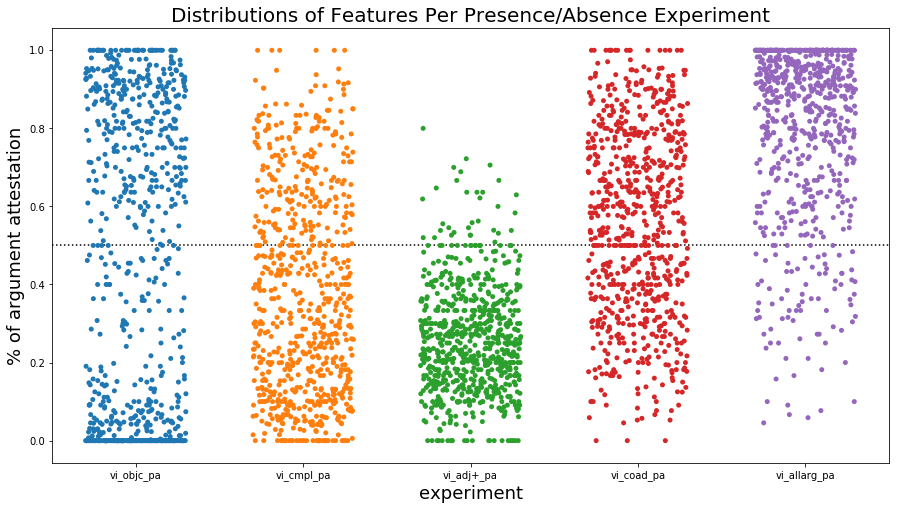

In [13]:
vi_datas = pd.DataFrame((experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()).loc['Objc']) # normalized objc data
vi_datas.columns = ('ratio of attestation',)
vi_datas['experiment'] = 'vi_objc_pa'

for exp_name, experiment in experiments.items():
    
    if exp_name == 'vi_objc_pa' or not re.match('vi_.*_pa', exp_name): # skip any non-pa experiments
        continue
        
    exp = experiment.data / experiment.data.sum() # normalize

    arg = next(i for i in exp.index if i != 'ø')
    
    datas = pd.DataFrame(exp.loc[arg])
    datas.columns = ('ratio of attestation',)
    datas['experiment'] = exp_name
    
    vi_datas = pd.concat((vi_datas, datas))

plt.figure(figsize=(15,8))
plt.title('Distributions of Features Per Presence/Absence Experiment', fontsize=20)
sns.stripplot(x='experiment', y='ratio of attestation', data=vi_datas, jitter=0.3)
plt.xlabel('experiment', fontsize=18)
plt.ylabel('% of argument attestation', fontsize=18)
plt.axhline(0.5, color='black', linestyle='dotted')

Points on the graph are individual verbs, for each of which we look at the percentage of its overall uses with the argument in question (e.g. the blue points show how often verbs occur with an object).

### Initial Observations

The combined, complement + adjunct experiment seems to have the most even distribution of features. The object presence/absence experiment appears to show the most separation between verbs. The adjunct tends to have <50% attestation, while the opposite is true for the allarg experiment.

It is possible to venture a few generalizations based on this visual:

* Verbs appear to exhibit a more even polarity between the presence/absence of an object argument.
* The number of verbs that occur with or without a complementizer appear to be fairly balanced, with a slight preference for <50% of those verbs' occurrences having a complement.
* There are more verbs with ≤50% of adjunct elements.
* The number of verbs with a higher proportion of complement or adjunct arguments is seems evenly distributed, with a slight preference for >50%.
* The number of verbs with a proportion >50% of any of the arguments appears to be high. 

#### Number of Verbs with 100% or 0% Objc

In [14]:
ratioedO = experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()
allO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] == 1.0]
noO = ratioedO.loc['Objc'][ratioedO.loc['ø'] == 1.0]

print(f'{allO.shape[0]} verbs that have an object 100% of the time...')
print(f'{noO.shape[0]} verbs that never occur with an object...')

39 verbs that have an object 100% of the time...
148 verbs that never occur with an object...


#####  Verbs with 100% Objects

In [15]:
#print(' | '.join(allO.index))

##### Verbs with 0% Objects

In [16]:
#print(' | '.join(noO.index))

In [17]:
# B.show(B.search('''

# clause
#     phrase function=Pred
#         word lex=BW>[ vs=qal

#     phrase function=Objc
# '''))

BW> with objects is a good example of the shortcomings of the ETCBC "object" label, which does not sharply distinguish between "objects" and "complements." Note however the group of verbs just beneath the 20% marker in the strip chart. Are many of these motion verbs like BW>?

In [18]:
smallO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] <= 0.20]
print(f'{smallO.shape[0]} verbs that have an object ≤20% of the time...')

289 verbs that have an object ≤20% of the time...


In [19]:
#print(' | '.join(smallO.index))

## Preparing for Similarity Analysis

For each specimen, calculate its similarity with all other specimens pairwise based on all experiments which they have in common. The similarity scores will be averaged across all of the shared experiments. All raw counts have been adjusted using the pointwise mutual information (pmi) score. Counts for 

### Averaged Similarity Scores

Average similarities across all experiments to derive a list of test cases.

In [20]:
sim_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for pairwise similarities
common_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for counting number of common experiments

for lex in specimens:
    for space_name, space in spaces.items():
        
        sim_measure = eval(f'space.{countType[space_name]}')
        
        if lex not in sim_measure.columns:
            continue
        
        sim_matrix[lex] = sim_matrix[lex].add(sim_measure[lex], fill_value=0)
        common_matrix[lex] += 1
        
sim = sim_matrix / common_matrix

In [21]:
#list(sim.columns)

In [22]:
sim['PYH[.qal']['PTX[.qal'] # random test

0.5903673728972471

In [23]:
sim['HJH[.qal'].sort_values(ascending=False).head(10)

NTN[.qal    0.612082
<FH[.qal    0.603892
BW>[.qal    0.547493
JY>[.qal    0.478234
QR>[.qal    0.471106
JCB[.qal    0.468395
HLK[.qal    0.467038
NPL[.qal    0.456240
<LH[.qal    0.455061
>MR[.qal    0.447714
Name: HJH[.qal, dtype: float64

In [24]:
sim['NTN[.qal'].sort_values(ascending=False).head(10)

FJM[.qal    0.743461
<FH[.qal    0.695756
BW>[.hif    0.649756
LQX[.qal    0.615713
HJH[.qal    0.612082
NF>[.qal    0.526348
QR>[.qal    0.519454
>MR[.qal    0.509996
CWB[.hif    0.502046
NGD[.hif    0.496463
Name: NTN[.qal, dtype: float64

### Looking at Surprise Word Similarities

One of the major goals of this project is to determine how verb meanings and classes are naturally distinguished by their context. היה is an interesting case of a verb which likely has no exact synonyms, but which exhibits similarity across all averaged experiments with words that are seemingly unsimilar such as נתן, עשה, בוא, etc. (see above). The purpose of gathering various kinds of contexts via the experiment parameters is to discover which contexts in particular are similar or different in various kinds of verbs. 

### Deriving Plot Arrangements for Similarity Analysis

The arrangment of experiment parameters on the plot is important, since I hope to use it to identify patterns. So here I develop an ordering and color scheme to be used with all of the plots.

##### Concept: Develop an ordering scheme based on specificity of parameters
I can attempt to arrange elements from more to less specific parameters. An example of a "specific" parameter would be one with lexical arguments, while a "general" parameter might only count the presence or absence of a given argument. Below is a concept of priorities:

1. verb grammar (vg)
    1. verb tense
2. verb domain (vd)
    1. simple domain
    2. embedded domain
    3. context clause chain
    4. context clause
    5. parallelism
    6. context window
3. verb inventories (allargs, adjunct, complement, object)
    1. presence
    2. animacy
    3. domain
    4. lexemes
4. verb frames
    1. same order as verb inventories

In [25]:
# make bar orders and map to colors

verb_grammar = ['vg_tense']

verb_domain = '''
vd_domain_simple
vd_domain_embed
vd_con_chain
vd_con_clause
vd_con_window
vd_par_lex
'''.strip().split('\n')

vi_pa = '''
vi_allarg_pa
vi_coad_pa
vi_adj+_pa
vi_cmpl_pa
vi_objc_pa
'''.strip().split('\n')

vi_animacy = '''
vi_subj_animacy
vi_allarg_animacy
vi_coad_animacy
vi_adj+_animacy
vi_cmpl_animacy
vi_objc_animacy
'''.strip().split('\n')

vi_domain = '''
vi_subj_domain
vi_allarg_domain
vi_coad_domain
vi_adj+_domain
vi_cmpl_domain
vi_objc_domain
'''.strip().split('\n')

vi_lex = '''
vi_allarg_lex
vi_coad_lex
vi_subj_lex
vi_adj+_lex
vi_cmpl_lex
vi_objc_lex
'''.strip().split('\n')

vf_pa = '''
vf_argAll_pa
vf_coad_pa
vf_adju_pa
vf_cmpl_pa
vf_obj_pa
'''.strip().split('\n')

vf_animacy = '''
vf_argAll_animacy
vf_coad_animacy
vf_adju_animacy
vf_cmpl_animacy
vf_obj_animacy
'''.strip().split('\n')

vf_domain = '''
vf_argAll_domain
vf_coad_domain
vf_adju_domain
vf_cmpl_domain
vf_obj_domain
'''.strip().split('\n')

vf_lex = '''
vf_argAll_lex
vf_coad_lex
vf_adju_lex
vf_cmpl_lex
vf_obj_lex
'''.strip().split('\n')

blues = sns.color_palette(palette='Blues')
reds = sns.color_palette(palette='Reds')

# map experiment groups to colors
color2experiment = (('gold', verb_grammar),
                    ('purple', verb_domain),
                    (blues[1], vi_pa),
                    (blues[2], vi_animacy),
                    (blues[4], vi_domain),
                    (blues[5], vi_lex),
                    (reds[1], vf_pa),
                    (reds[2], vf_animacy),
                    (reds[4], vf_domain),
                    (reds[5], vf_lex))

# make ordered tuple of colors
expcolors = tuple((exp, color) for color, exp_list in color2experiment # make tuple of colors
                        for exp in exp_list) 

**Below I prepare visualizer functions for examining similarities and differences in similarity scores.**

In [26]:
def get_sim_experiments(lex1, lex2, colors=expcolors, show=True, returnData=True, wordSet=None):
    '''
    Exports a barchart that illustrates the level
    of similarity between two lexemes per all experiments
    in the dataset.
    '''
    
    sims = dict() # temporarily hold similarity scores here
    
    # gather rated similarities between the two terms for every provided experiment
    for sp_name, space in spaces.items():
        
        sim_measure = eval(f'space.{countType[sp_name]}')
        wordSet = wordSet or {lex1, lex2}

        if wordSet & set(sim_measure.columns) != wordSet: # ensure both terms are in the space
            continue
            
        sims[sp_name] = sim_measure[lex1][lex2] # get similarity
        
    sims_ordered = collections.OrderedDict((exp[0], sims[exp[0]]) for exp in colors if exp[0] in sims) # customized order
    sims = pd.DataFrame(list(sims_ordered.items())) # drop into Dataframe
    sims.columns = ['experiment', 'score'] # set col names
    
    if show:
        # plot:
        plot_colors = tuple(expcol[1] for expcol in colors if expcol[0] in sims['experiment'].values)        
        plt.figure(figsize=(18, 8)) 
        sns.barplot(sims['experiment'], sims['score'], palette=plot_colors, orient='v')
        plt.xticks(rotation='vertical', fontsize=12)
        plt.xlabel('experiment', fontsize=18)
        plt.ylabel('adjusted similarity score', fontsize=18)
        plt.title(f'Scored Similarities between {lex1} and {lex2}', fontsize=20)
        
    if returnData:
        return sims
    
def compare_simPatterns(dataset1, dataset2, pairs='', colors=expcolors):
    '''
    Compare barchart similarity patterns accross two barcharts.
    The first dataset is the primary dataset and will be colored
    normally. The second dataset will be colored grey for comparison.
    '''
    
    data1Sims = list(reversed(dataset1['score']))
    data2Sims = list(reversed(dataset2['score']))
    xLocations = np.arange(dataset1.shape[0])
    barwidth = 0.8       # the width of the bars: can also be len(x) sequence
    plt.figure(figsize=(10, 15)) 
    p1 = plt.barh(xLocations, data1Sims, barwidth, color=sns.color_palette(palette='Reds')[3])
    p2 = plt.barh(xLocations, data2Sims, barwidth, color=sns.color_palette(palette='Blues')[4])
    plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
    
    plt.ylabel('experiment', fontsize=18)
    plt.xlabel('adjusted similarity scores', fontsize=18)
    plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)
    
    plt.legend((p1[0], p2[0]), (f'{pairs[0]}', f'{pairs[1]}'), fontsize=12)
    
def compareSets(set1, set2):
    '''
    Compare two pairs of words and their similarity differences.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    
    compare_simPatterns(dataset1, dataset2, pairs=(f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'))
    
def compareChange(set1, set2, colors=expcolors, returnData=False, showPlot=True):
    '''
    Compare two pairs of words and plot the positive or negative
    difference in similarities from set1 to set2.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]}, colors=colors)
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]}, colors=colors)
    
    change = dataset1.copy() 
    change['score'] = change['score'] - dataset2['score']
    #change['score'] = change['score'] / dataset1['score'] # don't divide since all experiments are now fairly normal
    
    datachange = list(reversed(change['score']))
    blue = sns.color_palette(palette='Blues')[3]
    red = sns.color_palette(palette='Reds')[4]
    colors = [blue if score > 0 else red for score in datachange]
    
    pairs = f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'
    
    if showPlot:
        xLocations = np.arange(change.shape[0])
        barwidth = 0.8       # the width of the bars: can also be len(x) sequence
        plt.figure(figsize=(10, 15)) 
        plt.barh(xLocations, datachange, barwidth, color=colors)
        plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
        plt.ylabel('experiment', fontsize=18)
        plt.xlabel('adjusted similarity score differences', fontsize=18)
        plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)
    
    if returnData:
        return (dict(zip(list(reversed(dataset1['experiment'])), datachange)))
    
def plotTop(scores, lex):
    '''
    Plot the top most similar terms
    using their rank and similarity score.
    '''
    plt.xticks(range(0, scores.shape[0]), scores.index)
    plt.title(f'Plotted Similarity Scores to {lex}')
    plt.ylabel('similarity score')
    plt.xlabel('Most Similar Terms in Ranked Order')
    plt.scatter(range(0, scores.shape[0]), scores)
    plt.plot(range(0, scores.shape[0]), scores)
    
def plotPa(term1, term2, experiment):
    '''
    Plot side-by-side bar charts for presence
    absence experiments to show the raw differences
    in tendencies.
    '''
    
    width = 0.4
    fig, ax = plt.subplots(figsize=(6, 5))    
    term1Dat = spaces[experiment].raw_norm[term1]
    term2Dat = spaces[experiment].raw_norm[term2]
    
    print(term1)
    print(term1Dat, '\n')
    print(term2)
    print(term2Dat, '\n')
    
    index = np.arange(term1Dat.shape[0], step=1)
    ax.bar(index, term1Dat, width, label=term1)
    ax.bar(index+width, term2Dat, width, label=term2)
    ax.legend()
    ax.set_xticks(index+width/2)
    ax.set_xticklabels(term1Dat.index, fontsize=14)
    ax.set_ylabel('attested proportion', fontsize=14)
    ax.set_title(f'scores for {experiment}', fontsize=15)
    
def topCommon(term1, term2, experiment, count_type='pmi'):
    '''
    Find the top common values between two terms within
    a given experiment.
    '''  
    
    count_measure = eval(f'spaces["{experiment}"].{count_type}')
    
    t1Top = count_measure[term1].sort_values(ascending=False)
    t2Top = count_measure[term2].sort_values(ascending=False)
    
    common = t1Top[t2Top > 0]
    common = common[common > 0]
    averaged_common = (common + t2Top[common.index]) / 2
    
    averaged_common = pd.DataFrame(averaged_common, columns=['averaged'])
    averaged_common[term1] = t1Top[common.index]
    averaged_common[term2] = t2Top[common.index]
    
    return averaged_common.sort_values(by='averaged', ascending=False)

def topUncommon(term1, term2, experiment, count_type='pmi', focus=''):
    '''
    Find the top uncommon values between two terms within
    a given experiment.
    '''  
    
    count_measure = eval(f'spaces["{experiment}"].{count_type}')
    
    t1Top = count_measure[term1]
    t2Top = count_measure[term2]
    
    uncommon = abs(t1Top - t2Top) # absolute diff
    uncommon = pd.DataFrame(uncommon, columns=['difference'])
    uncommon[term1] = t1Top[uncommon.index]
    uncommon[term2] = t2Top[uncommon.index]
        
    if not focus:
        return uncommon.sort_values(by='difference', ascending=False)
    else:
        return uncommon[uncommon[focus] > 0].sort_values(by='difference', ascending=False)

## Similarity Analyses

We will analyze the top ten words ranked by frequency of experiment data counts. For each word we look at the top 5 most similarly ranked words and analyze two categories: intuitive matches and surprising matches. Intuitive matches are those for which we can recognize a valid (as humanly judged) semantic similarity. We visualize the specific scores of similarity per experiment with barcharts. The charts allow us to map specific areas of similarity and dissimilarity based on the test parameters of the experiments. In doing so, we explore how similarity is multifaceted and whether there are any perceptible differences in intuitively and surprisingly matched terms. Another barchart is used to show differences between intuitively matched terms and surprisingly matched terms. This helps to isolate which experiment parameters consistently yield differences between intuitive and surprising matches.

### Deriving a Case Study Set

Further above we have generated a frequency count for each lexeme in the specimen set. This allows us to select the top most common lexemes for the case study as shown below.

In [27]:
freq_count.most_common(10)

[('>MR[.qal', 47974.0),
 ('HJH[.qal', 34658.0),
 ('<FH[.qal', 22837.0),
 ('BW>[.qal', 19062.0),
 ('NTN[.qal', 18194.0),
 ('HLK[.qal', 13360.0),
 ('R>H[.qal', 10784.0),
 ('DBR[.piel', 10002.0),
 ('CM<[.qal', 9999.0),
 ('LQX[.qal', 9136.0)]

We can create a loose list of groups for these lexemes based on perceived intuitive similarities. These groups only serve the purpose of getting a sense of the lexical variety reflected in the most common set, and thus they do not go towards the analysis itself.

In this top ten set, we can see six general groups of verbs:

1. **communication** - >MR[.qal, DBR[.piel
2. **state** - HJH[.qal
3. **doing/making** - <FH[.qal
4. **moving** - BW>[.qal, HLK[.qal
5. **manipulating** - NTN[.qal, LQX[.qal
6. **perceiving** - R>H[.qal, CM>.qal

There is good variety in this top 10 set. We begin with these top ten, to analyze their top-rated most-similar terms, and to compare surprising similarities against intuitive ones.

### אמר.qal

We begin the word-by-word evaluation with אמר ("to say"). The top five most similar terms are based on the average of similarity scores across all available experiments for אמר. They are listed below along with the averaged similarity score.

Similarity Scores with >MR
 QR>[.qal     0.643052
DBR[.piel    0.629496
NTN[.qal     0.531245
NGD[.hif     0.529970
<FH[.qal     0.510799
Name: >MR[.qal, dtype: float64 



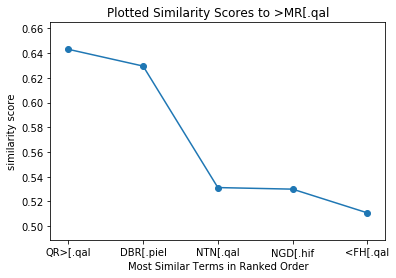

In [28]:
say_top_sim = sim['>MR[.qal'].sort_values(ascending=False).head(5) # get top 5 elements
plotTop(say_top_sim, '>MR[.qal')
print('Similarity Scores with >MR\n', say_top_sim, '\n')

קרא is ranked most similar at 0.70. דבר is close at 0.68. There is a 10 point decrease at the third ranked word, נגד, which the plot illustrates. נתן and שלח are surprising similarities which will need to be explored.

We can note that the first three terms are good intuitive matches. The last two, נתן and שלח, are surprising matches. Is שלח included here because of its occasional use in messenger/communication situations, or for another reason? What is the cause for the similarity of נתן and שלח with אמר?

To answer these questions, we now turn to the analysis and comparison of similarity scores across the experiments.

#### Similarity Patterns for Intuitive Matches to אמר

#### אמר and קרא

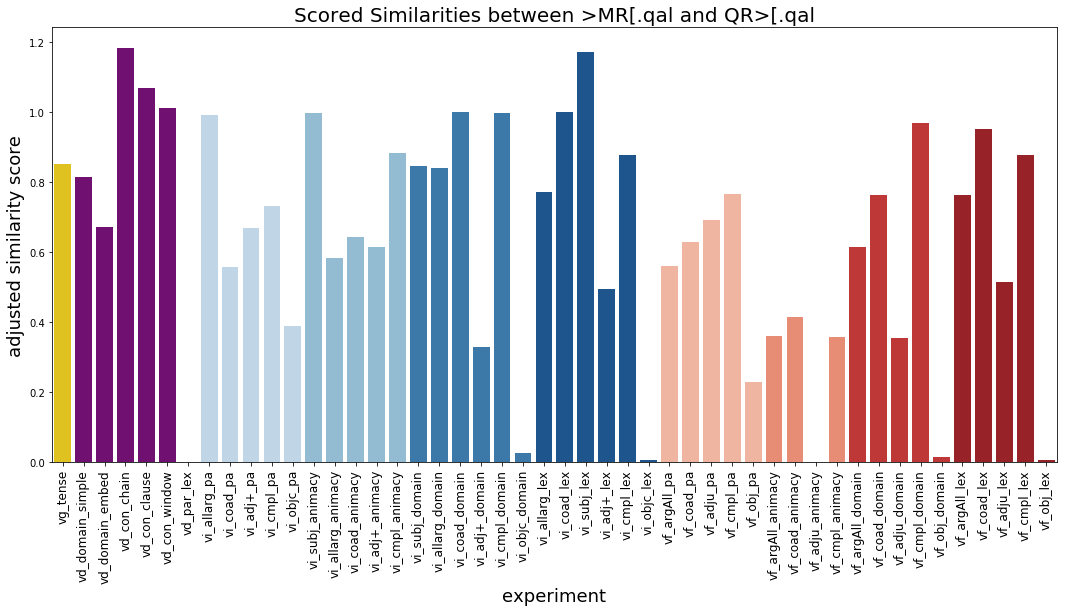

In [29]:
say_call = get_sim_experiments('>MR[.qal', 'QR>[.qal')

Each score has been normalized according to the 75 percentile maximum similarity values per experiment so that the scores are judged in relation to the experiment's performance.

Each color group represents a different experiment strategy while different shades represent different data points, with increasing darkness for increasing specificity of the experiments' datapoint. Thus, higher bars within darker shaded groups will presumably show more specific similarities.

Starting with the `vg` and `vd` experiments, we see a high agreement in verb tense as well as simple domain. For the other `vd` experiments there is decreasing similarity as the specificity of the datapoint increases to the context of a window. There does not appear to be any parallelism shared between אמר and קרא (`vd_par_lex`).

In the inventory `pa` experiments we see high levels of agreement between the adju and cmpl experiments. The allarg experiment is probably higher due to the high agreement in adju and cmpl. The object experiment is lower (<0.4) in comparison to the adju and cmpl experiments.

In the inventory `animacy` experiments the subj and cmpl scores stand out above the others. There is a lot of agreement, then, on the animacy of the actant and the animacy of the complement element. For communicative verbs this is probably significant: a living subject communicating **to** a living complement. The coad experiment is also slightly higher, perhaps due to the increase in the cmpl agreement.

In the inventory `domain` experiments there is highest agreement in the coad and cmpl experiments. Allarg and subject are also high. Since allarg includes the cmpl and adju, it makes sense that it would also be slightly higher. The high level of agreement with subject domain corresponds with a high level of subject animacy agreement. The adjunct domain is the second lowest. Probably most notable of all, though, is the very small level of agreement in the object experiment. This corresponds with lower levels of agreement seen in the `pa` experiments (N.B. objc is absent from the animacy experiment due to lack of data).

In the inventory `lex` experiments coad again stands out. Could it be that cmpl and adju agreement are combining to create even stronger levels of agreement in the coad experiment? Subject is the highest of the levels, just as is it is in the animacy experiments. Which lexemes might be co-occurring in this slot regularly? The adjunct experiment is again second lowest, as in the domain experiemnts. But the object experiment again shows the least amount of agreement.

Moving into the frame `pa` experiments, the coad, adju, and cmpl experiments show high levels of agreement. The pattern between those three experiments is nearly exactly the same as the vi `pa` experiments. The allarg experiment, on the other hand, is much lower than its `pa` counterpart. This may be expected since the allarg frame experiment would require similarity across more diverse categories. Like with the vi experiments, objc has a much lower similarity at ~0.60. It's noteworthy that the adju experiment here is relatively equivalent with the cmpl (as in the inventory experiments) since the adju has consistently scored lower across animacy, domain, and lex experiments. This shows that while >MR and QR> have a similar tendency to attract adjuncts, they adjuncts themselves are particularly different. This could be an interesting area of investigation.

In the frame `animacy` experiments, we see that adju has essentially zero similarity. This needs to be investigated. It shoud be noted that animacy experiments have much less data to work on, so a slight deficiency in one or another value could result in changes to this value. However, the lower level of animacy agreement in the adju experiment *does* correspond with its lower attestation in the vi experiments. The coad experiment is slightly higher than both argAll and cmpl, but in general all three are fairly close in agreement.

In the frame domain experiments the cmpl experiment shows the strongest similarity, which results in a higher score for the coad experiment. As in the inventory versions, the adju is second lowest while the object shows the most separation. 

The lexical frame experiments show the same pattern and shape as the domain: high agreement in cmpl with a corresponding highest agreement in the coad experiment. argall, as a result, is also higher. The adju experiment is lower while the objc experiment is lowest.

#### Synthesis
\>MR and QR> share very similar contexts at the discourse domain and clause levels. They also have very similar preferences for attracting the presence of adjuncts and complements, but they differ in their simple preference for an object. >MR and QR> differ even more in the *kind* of objects which they prefer, both by semantic domain and lexeme. The two verbs also tend to select different adjuncts in the animacy, semantic domain, and lexeme experiments. However, >MR and QR> share a high similarity in their complements across animacy, semantic domain, and lexical categories. Finally, both >MR and QR> share similar kinds of subjects. Notably, they share similarity in subject and complement animacy, which may be a key factor in differentiating communication verbs like these.

#### Investigation

The analysis of the similarity plot shows high agreement in complement categories as well as subject animacy and lexemes. Here we dive deeper into the specific similarities with `topCommon`, which pulls out the top similar features in common for a given experiment.

First, we see high levels of similarity in the discourse context experiments. We look at the top rated similarities in the window experiment, which records the lexemes to the left and right of the verbs.

In [30]:
topCommon('>MR[.qal', 'QR>[.qal', 'vd_con_window').head(10)

,averaged,>MR[.qal,QR>[.qal
L>_<MJ/,8.625709,8.625709,8.625709
J<BY/,7.803781,7.303781,8.303781
N<MJ=/,7.717750,8.510232,6.925269
CMCWN/,7.378714,8.247197,6.510232
GJXZJ/,7.333228,8.625709,6.040746
NPTLJ/,7.303781,7.303781,7.303781
BRWK/,7.303781,7.303781,7.303781
MJKJHW/,7.248265,8.040746,6.455784
>KJC/,7.217750,8.510232,5.925269
CM<J=/,7.110835,7.403316,6.818354


The frame, complement, animacy experiment yields important similarities in the shared complements of אמר and קרא:

In [31]:
topCommon('>MR[.qal', 'QR>[.qal', 'vf_cmpl_animacy')

,averaged,>MR[.qal,QR>[.qal
>L_animate,4.417922,6.139394,2.696450
L_animate,3.551028,4.445276,2.656780
L_inanimate,2.891350,3.454115,2.328584
<L_inanimate,1.054641,0.811928,1.297354


N.B. that the counts are ppmi adjusted counts. The complement also held high similarity in the frame domain experiment:

In [32]:
topCommon('>MR[.qal', 'QR>[.qal', 'vf_cmpl_domain').head(10) # show top 10

,averaged,>MR[.qal,QR>[.qal
>L_Professions,6.371559,6.371559,6.371559
L_Gather,5.901006,6.693487,5.108524
L_Control,5.871559,6.371559,5.371559
L_Professions,5.386132,5.886132,4.886132
>L_People,5.168315,6.398031,3.938599
L_Waterbodies,5.108524,5.108524,5.108524
L_Names of Landforms,5.108524,5.108524,5.108524
L_Names of Groups,4.898505,5.190987,4.606024
>L_Names of People,4.866702,6.918107,2.815297
L_Names of People,4.844022,5.447248,4.240797


These commonalities show the actions of both קרא and אמר being directed *towards* people (professions, gather[ings], people, names of groups). On a few occasions the action is directed towards performing an act of taking control (e.g. L_Control) using the verb שבה (Isa 61:1), אסר (Isa 49:9), or כבשׁ (as in 2 Chr 28:10). In the cases of L_Names of Landforms, the referents are Zion (Isa 52:7) and Hermon (Deut 3:9) as personified cities. In Ezek 6:3, YHWH speaks "to the channels" which is the source of L_Waterbodies.

The analysis also showed key *differences* in object and adjunct use. Here we will try to tease this out a bit more, and find out *which* object and adjunct instances in particular are different between the two terms. First we look at the raw counts in the inventory and frame presence/absence experiments.

>MR[.qal
Objc    0.921019
ø       0.078981
Name: >MR[.qal, dtype: float64 

QR>[.qal
Objc    0.489666
ø       0.510334
Name: QR>[.qal, dtype: float64 



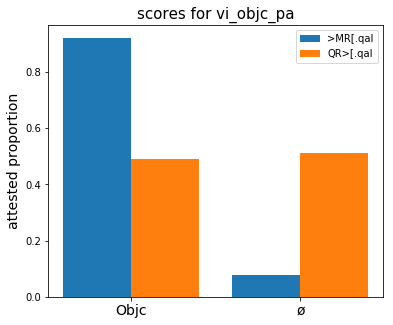

In [33]:
plotPa('>MR[.qal', 'QR>[.qal', 'vi_objc_pa')

The data shows that >MR nearly always (92%) occurs alongside an object. Our export of the data counts the beginning of speech as an object. QR>, on the other hand, is evenly divided between its use with and without an object. Let's take a closer look at the cases where QR> occur without an object.

In [34]:
B.show(experiments['vi_objc_pa'].target2basis2result['QR>[.qal']['ø'][:10])



**verse** *1*





**verse** *2*





**verse** *3*





**verse** *4*





**verse** *5*





**verse** *6*





**verse** *7*





**verse** *8*





**verse** *9*





**verse** *10*



We can see that a common reason קרא often does not take the object is because it is used in conjunction with אמר, which will take the object instead. This happens most clearly in the formulaic statement: קרא לאמר. The raw counts for this occurrence is below.

In [35]:
print('Occurrences of QR> + L + >MR: \t', experiments['vi_adj+_lex'].data['QR>[.qal']['L_>MR['])

Occurrences of QR> + L + >MR: 	 23.0


We can make a further note here that this pattern gives some corroborating evidence as to the close meaning of קרא and אמר, especially since אמר often occurs with this same pattern:

In [36]:
print('Occurrences of >MR + L + >MR: \t', experiments['vi_adj+_lex'].data['>MR[.qal']['L_>MR['])

Occurrences of >MR + L + >MR: 	 113.0


Besides this formula, we see in the occurrences above that קרא is also frequently followed by אמר in the next sentence (i.e. call out -> say).

The experiments have thus noticed a subtle difference in meaning between אמר and קרא in their tendencies to attract objects. Namely, אמר almost always requires the beginning of a direct speech section (marked herein as the object), whereas קרא takes an object only about half of the time.

Another observation from the analysis above is that >MR and QR> frequently take different *kinds* of objects. This is seen in the relatively lower scores for object experiments in the remaining categories. Let's take a look at the top scores for the two terms to see if we can discern where major differences lie.

In [37]:
topUncommon('>MR[.qal', 'QR>[.qal', 'vi_objc_domain').head(20)

,difference,>MR[.qal,QR>[.qal
>M_Bless,7.936638,7.936638,0.000000
L_Strong,7.936638,7.936638,0.000000
Heat,7.936638,0.000000,7.936638
>CR_Open,7.936638,7.936638,0.000000
L_Speak,7.936638,7.936638,0.000000
>CR_Ingest,7.936638,7.936638,0.000000
L_Possess,7.936638,7.936638,0.000000
L_Non-Exist,7.936638,7.936638,0.000000
>CR_Flee,7.936638,7.936638,0.000000
KJ_Witnesses,7.936638,0.000000,7.936638


We see a bigger tendency amongst the data for אמר for the objects to consist of prepositional phrases which would be part of object clauses. קרא, on the other hand, has mainly simple noun phrases for the most part. We can also see that "Names" occur at least 3 times in the קרא's top list. Keep in mind that these scores are the PPMI adjusted scores, which aims to maximize surprising lexical occurrences in proportion to their overall sample sizes. If we look at the raw counts, we can see this "naming" tendency come out even more:

In [38]:
topUncommon('>MR[.qal', 'QR>[.qal', 'vi_objc_domain', count_type='raw').head(20)

,difference,>MR[.qal,QR>[.qal
Name,106.0,0.0,106.0
Names of People,73.0,0.0,73.0
Names of Locations,34.0,0.0,34.0
Names of Landforms,11.0,0.0,11.0
Happen,10.0,2.0,12.0
Ingest,8.0,0.0,8.0
Names of Deities,7.0,0.0,7.0
Groups,5.0,0.0,5.0
Names of Constructions,4.0,0.0,4.0
Kinship,4.0,0.0,4.0


If we look at the lexical experiments, we can see the same tendency reflected:

In [39]:
topUncommon('>MR[.qal', 'QR>[.qal', 'vi_objc_lex').head(20)

,difference,>MR[.qal,QR>[.qal
NPTLJ/,8.252665,0.000000,8.252665
YPNT_P<NX/,8.252665,0.000000,8.252665
JKJN/,8.252665,0.000000,8.252665
<MQ/,8.252665,0.000000,8.252665
<MNW_>L/,8.252665,0.000000,8.252665
KJ_CGGH/,8.252665,8.252665,0.000000
GRCM/,8.252665,0.000000,8.252665
XRVM/,8.252665,0.000000,8.252665
RXBWT/,8.252665,0.000000,8.252665
KJ_BL<==[,8.252665,8.252665,0.000000


In the אמר top list we see content of speech with verbs such as לדרש (say -> to seek) or לכנס (say -> to gather). In the קרא top list we see nouns and proper nouns. We can say, then, that one of the primary differences between אמר and קרא is the tendency of קרא to take nouns as direct objects in a naming context; אמר's objects are distinguished by marking action.

One of the distinguishing similarities between אמר and קרא was in the subject animacy experiment. These two verbs have high preferences for animate subjects, as would be expected:

>MR[.qal
animate      0.992513
inanimate    0.007487
Name: >MR[.qal, dtype: float64 

QR>[.qal
animate      0.991453
inanimate    0.008547
Name: QR>[.qal, dtype: float64 



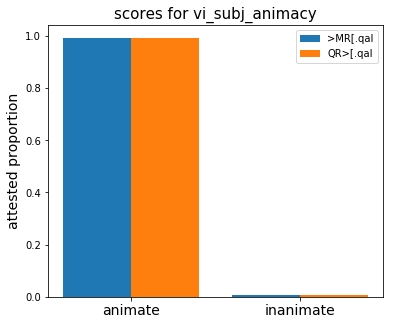

In [40]:
plotPa('>MR[.qal', 'QR>[.qal', 'vi_subj_animacy')

There are cases in our data where inanimate objects are personified and begin speaking. We show a few of those cases below (results cut off at 5).

In [41]:
B.show(experiments['vi_subj_animacy'].target2basis2result['>MR[.qal']['inanimate'][:5], condenseType='clause')



**clause** *1*





**clause** *2*





**clause** *3*





**clause** *4*





**clause** *5*



The strong agreement in subject animacy similarity is paired with a high agreement of complement similarity. Here are the top common scores for both terms in the complement animacy frames:

In [42]:
topCommon('>MR[.qal', 'QR>[.qal', 'vf_cmpl_animacy')

,averaged,>MR[.qal,QR>[.qal
>L_animate,4.417922,6.139394,2.696450
L_animate,3.551028,4.445276,2.656780
L_inanimate,2.891350,3.454115,2.328584
<L_inanimate,1.054641,0.811928,1.297354


Both verbs often direct their action from an animate subject with either the preposition אל or ל towards an animate object. We can note an interesting difference with קרא that ties back its naming tendency; see that "animate" without a qualifying preposition is included. This is presumably the person which is being named.

Finally, אנר and קרא consistently had lower levels of similarity in the adjunct experiments. This happens even though both have relatively higher similarity in the presence/absence experiment(closer to the complement). Why might that be the case?

In [43]:
topUncommon('>MR[.qal', 'QR>[.qal', 'vi_adj+_domain').head(20)

,difference,>MR[.qal,QR>[.qal
>L_Shame,7.761551,7.761551,0.000000
B<D/_Evil,7.761551,0.000000,7.761551
J<N/>CR_Space,7.761551,7.761551,0.000000
>L_Domestic Animals,7.761551,0.000000,7.761551
L_Bald,7.761551,0.000000,7.761551
MN_Shine,7.761551,0.000000,7.761551
<L_Crops,7.761551,0.000000,7.761551
K_Name,6.761551,0.000000,6.761551
L_Hang,6.761551,6.761551,0.000000
>L_Possess,6.761551,0.000000,6.761551


The differences here are diverse. We can see a slight tendency for the prepsition ב with אמר in conjunction with various kinds of "speaking" verbs like curse and lament. קרא has more references to landscapes and time references (possibly from the ETCBC `Loca` and `Time` tags. At this point it is difficult to perceive where the differences are. 

Diving into the raw scores helps:

In [44]:
topUncommon('>MR[.qal', 'QR>[.qal', 'vi_adj+_domain', count_type='raw').head(20)

,difference,>MR[.qal,QR>[.qal
L_Speak,88.0,112.0,24.0
<D_Time,8.0,1.0,9.0
L_Move,8.0,10.0,2.0
MN_Orientation,5.0,0.0,5.0
B_Name,5.0,1.0,6.0
B_Perception,5.0,0.0,5.0
L_Dead,4.0,4.0,0.0
B_Time,4.0,17.0,13.0
MN_Universe,3.0,0.0,3.0
Event Referents: Location,3.0,0.0,3.0


We see references to space and time amongst the קרא data (though time is also frequent in אמר). The adjunct with מן happens 3 times in the קרא list but not at all with אמר. Let's look closer at these instances.

In [45]:
B.show(experiments['vi_adj+_domain'].target2basis2result['QR>[.qal']['MN_Universe'], condenseType='clause')



**clause** *1*





**clause** *2*





**clause** *3*



In [46]:
B.show(experiments['vi_adj+_domain'].target2basis2result['QR>[.qal']['MN_Orientation'], condenseType='clause')



**clause** *1*





**clause** *2*





**clause** *3*





**clause** *4*





**clause** *5*



Below looks for *any* cases where אמר occurs alongside מן in our dataset. It finds none:

In [47]:
[experiments['vi_adj+_domain'].target2basis2result['>MR[.qal'][b] for b in experiments['vi_adj+_domain'].target2basis2result['QR>[.qal'] if b.startswith('MN')]

[[], [], [], [], [], [], [], [], []]

This difference shows that קרא occurs with a preposition that indicates separation or source. We can tease this out further:

In [48]:
spaces['vf_argAll_animacy'].pmi['QR>[.qal'].sort_values(ascending=False).head(5) # N.B. these are ppmi adjusted scores

Cmpl.L_animate|Cmpl.L_inanimate                  7.693487
Cmpl.L_animate|adj+.>L_animate|adj+.inanimate    7.693487
Cmpl.>L_animate|adj+.MN_inanimate                7.693487
Cmpl.L_inanimate|Objc.KJ_animate                 7.693487
Cmpl.B_inanimate|Cmpl.L_animate                  7.693487
Name: QR>[.qal, dtype: float64

Note the third-ranked frame with an animate complement and a MN+inanimate adjunct. This shows the action that is directed towards an animate object, a feature which קרא and אמר have in common, with an adjunct that קרא and אמר do not have in common. This is a nice distinction between these two verbs.

#### Conclusion on אמר and קרא

אמר and קרא share common contexts and frequently occur together. They are similar in their preference for animate subjects and complements, and they share similar prepositional phrases with אל or ל indicating the action *towards* the animate complement. The verbs differ, though, in their object and adjunct preferences. אמר nearly always takes speech as a direct object, while קרא is more flexible and can occur with or without an object 50% of the time. When either verb does take an object, there are differences in the domain and lexical choices of their objects. Namely, קרא more frequently takes proper noun phrases as objects, indicating its use to refer to naming. In the case of adjunct preference, קרא is also distinct in its use of מן to indicate the source of the action. It seems that קרא may also occur more often with adjuncts representing points in time or space but this hypothesis needs to be more thoroughly tested.

#### אמר and דבר

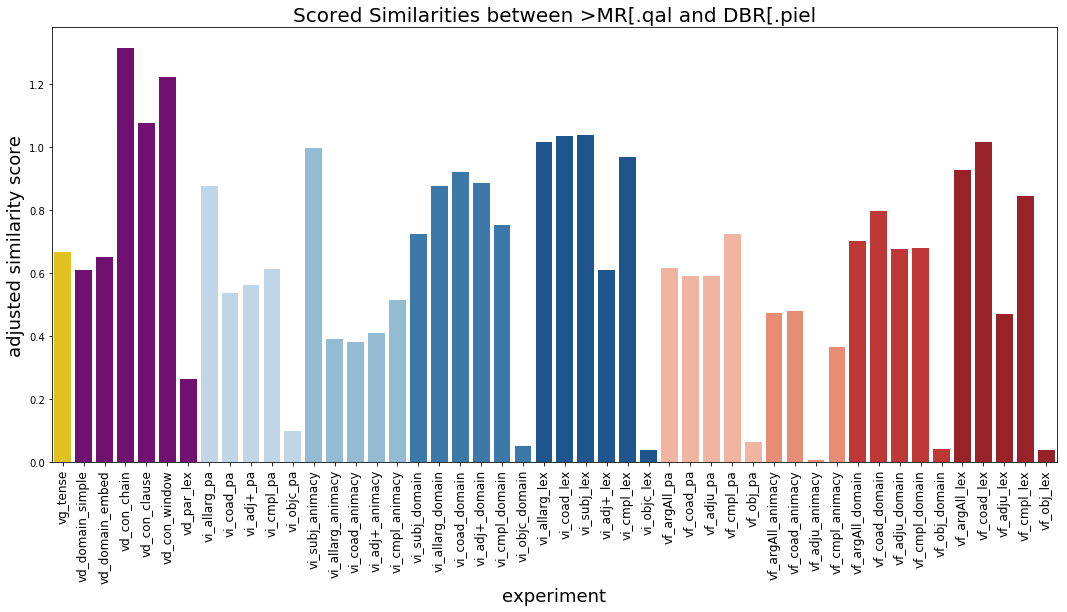

In [49]:
say_speak = get_sim_experiments('>MR[.qal', 'DBR[.piel')

The highest levels of agreement between אמר and דבר are seen in the vd experiments, where clause chain context is the highest, followed by the window contexts. We can find the top common context words that were found below:

In [50]:
topCommon('>MR[.qal', 'DBR[.piel', 'vd_con_window').head(10)

,averaged,>MR[.qal,DBR[.piel
NTN/,7.803781,8.888743,6.718818
GJXZJ/,7.333228,8.625709,6.040746
MJKJHW/,7.248265,8.040746,6.455784
>XJTPL/,7.125709,7.625709,6.625709
>LJC</,7.060638,8.268157,5.853119
MRJ/,7.040746,7.040746,7.040746
NBWT/,7.040746,7.040746,7.040746
JRMJHW/,6.946828,7.835632,6.058024
NBL/,6.925269,6.925269,6.925269
CVR[,6.833228,6.040746,7.625709


The majority of these terms are proper nouns. We do see שׁטר (participle, "officer"). 

We see high levels of agreement in the pa inventory experiments; allarg is higher due to the combined value of those experiments. We can notice that the object experiment, though, is much lower in its similarity, as was the case between אמר and קרא. Let's look more closely at `vi_objc_pa`. 

>MR[.qal
Objc    0.921019
ø       0.078981
Name: >MR[.qal, dtype: float64 

DBR[.piel
Objc    0.283664
ø       0.716336
Name: DBR[.piel, dtype: float64 



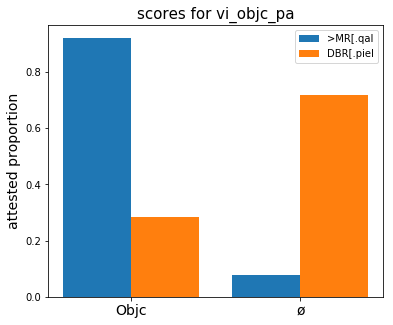

In [51]:
plotPa('>MR[.qal', 'DBR[.piel', 'vi_objc_pa')

דבר has an aversion for objects that is even stronger than what we saw for קרא (which was about 50/50). We can look at some examples:

In [52]:
B.show(experiments['vi_objc_pa'].target2basis2result['DBR[.piel']['ø'][:10])



**verse** *1*





**verse** *2*





**verse** *3*





**verse** *4*





**verse** *5*





**verse** *6*





**verse** *7*





**verse** *8*





**verse** *9*





**verse** *10*



Much like קרא, we notice that when the content of speech is introduced, the verb אמר is introduced, often with לאמר. But the verb דבר itself prefers object-less clauses. Complements such as את ("with") appear with דבר. This unsimilarity in object preference is also reflected in the rest of the object experiments. The kinds of objects that דבר *does* appear with refer to speech or a kind of speech, but not to its object.

In [53]:
experiments['vi_objc_lex'].data['DBR[.piel'].sort_values(ascending=False).head(10)

DBR/     64.0
KL/      11.0
MCPV/     9.0
VWBH/     6.0
VWB/      6.0
CW>/      6.0
CQR/      6.0
KZB/      5.0
R<H/      5.0
SRH/      4.0
Name: DBR[.piel, dtype: float64

We can also see that as compared to אמר, this verb occurs much less often with daughter clauses that describe an action:

In [54]:
topUncommon('>MR[.qal', 'DBR[.piel', 'vi_objc_lex').head(10)

,difference,>MR[.qal,DBR[.piel
KJ_CGGH/,8.252665,8.252665,0.000000
ZKR[,8.252665,8.252665,0.000000
C_HBL/,8.252665,8.252665,0.000000
>CR_>KL[,8.252665,8.252665,0.000000
KJ_BL<==[,8.252665,8.252665,0.000000
YX/,8.252665,0.000000,8.252665
>CR_NWS[,8.252665,8.252665,0.000000
BQC[,8.252665,8.252665,0.000000
XLQ=/,8.252665,0.000000,8.252665
L_<MD[,8.252665,8.252665,0.000000


As with אמר and קרא, subject animacy is highly similar between אמר and דבר. This, again, might be expected due to the meaning of these verbs. What of the complement animacy? We say the similarity in complements play an important role in the אמר & קרא pairing. In this pairing the complement experiments do not stand out as much. We can visualize the specific differences between the two pairings using `compareChange`, which plots the change in similarity when moving from one pairing to another. This can help us isolate major areas of differences between the two pairs. 

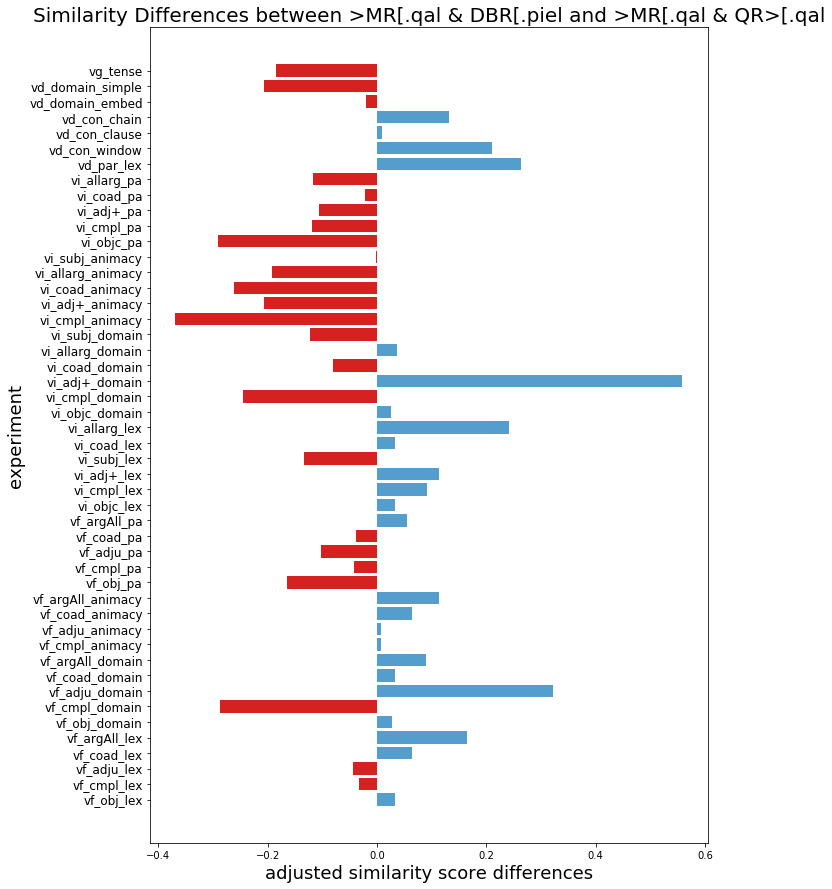

In [55]:
compareChange(('>MR[.qal', 'DBR[.piel'),('>MR[.qal', 'QR>[.qal'))

Here we see that דבר has advantages over קרא in its adjunct similarity with אמר, primarily between the vi and vf domain experiments. All other similarities dip as compared with קרא. We see the biggest decreases in complement animacy and domain similarity in this pairing. There is a difference in preference for the complement between אמר and דבר, with the latter occuring with the complement more frequently:

>MR[.qal
Cmpl    0.375498
ø       0.624502
Name: >MR[.qal, dtype: float64 

DBR[.piel
Cmpl    0.648199
ø       0.351801
Name: DBR[.piel, dtype: float64 



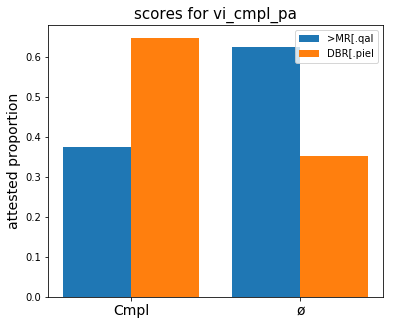

In [56]:
plotPa('>MR[.qal', 'DBR[.piel', 'vi_cmpl_pa')

But it is also important to note that the complement experiments remain high when compared amongst the other experiments. Here are the similarities and differences in select complement experiments:

In [57]:
topCommon('>MR[.qal', 'DBR[.piel', 'vi_cmpl_animacy')

,averaged,>MR[.qal,DBR[.piel
>L_animate,5.423023,5.999025,4.847022
<L_animate,2.942553,2.476110,3.408996


Here we see that אמר and דבר share the similarity found with קרא, i.e. directed action towards a living complement. But why might the complement category be rated so much lower than in the previous pair?

In [58]:
topUncommon('>MR[.qal', 'DBR[.piel', 'vi_cmpl_animacy').head(9)

,difference,>MR[.qal,DBR[.piel
>T==_animate,4.423044,0.000000,4.423044
L_animate,4.388867,4.388867,0.000000
L_inanimate,3.622353,3.622353,0.000000
<M_animate,3.293196,0.000000,3.293196
B_animate,2.144152,0.000000,2.144152
<L_inanimate,1.205904,1.205904,0.000000
>L_animate,1.152003,5.999025,4.847022
<L_animate,0.932886,2.476110,3.408996
<D_animate,0.000000,0.000000,0.000000


We can note key differences here in preposition preference. דבר takes complements with an accompaniment sense "with": >T, B, and <M. דבר also does not occur with ל, using אל instead (It's important to note that דבר *does* occur with L 10 times in the raw counts; but these counts are apparently too neglible for the ppmi in comparison to their overall use).

The most significant improvements in similarity between דבר and אמר happen in the adjunct category. Why might that be the case? We see that the biggest jump comes from the adjunct domain experiments. We look at the common values below.

In [59]:
topCommon('>MR[.qal', 'DBR[.piel', 'vi_adj+_domain').head(10)

,averaged,>MR[.qal,DBR[.piel
B_Confident,5.176589,5.176589,5.176589
L_Speak,5.138114,4.698541,5.577687
B_Vision,5.094601,5.887082,4.302120
<L_Furnishings,4.761551,4.761551,4.761551
Perception,4.761551,4.761551,4.761551
B_Non-See,4.454196,3.954196,4.954196
B_Name,4.354661,2.854661,5.854661
K_Speak,4.261380,3.324146,5.198615
B_Know,4.061112,4.061112,4.061112
B_Names of Landforms,3.617695,3.117695,4.117695


In [60]:
topCommon('>MR[.qal', 'DBR[.piel', 'vf_adju_domain').head(10)

,averaged,>MR[.qal,DBR[.piel
K_Speak|L_Speak,6.406891,5.906891,6.906891
B_Vision,5.962406,6.754888,5.169925
<L_Furnishings,5.169925,5.169925,5.169925
L_Speak,4.978092,4.558967,5.397216
B_Confident,4.906891,4.906891,4.906891
B_Name,4.310568,2.906891,5.714246
K_Speak,3.791413,2.791413,4.791413
B_Ingest,3.791413,3.791413,3.791413
L_Know,3.134301,3.134301,3.134301
L_Dead,3.111909,3.404390,2.819428


These domains are associated with **communication** (L_Speak, K_Speak) and **human actions** (B_Confident, B_Vision, Perception, B_Non-See).

In [61]:
B.show(experiments['vi_adj+_domain'].target2basis2result['DBR[.piel']['B_Confident'])



**verse** *1*



#### אמר and נגד

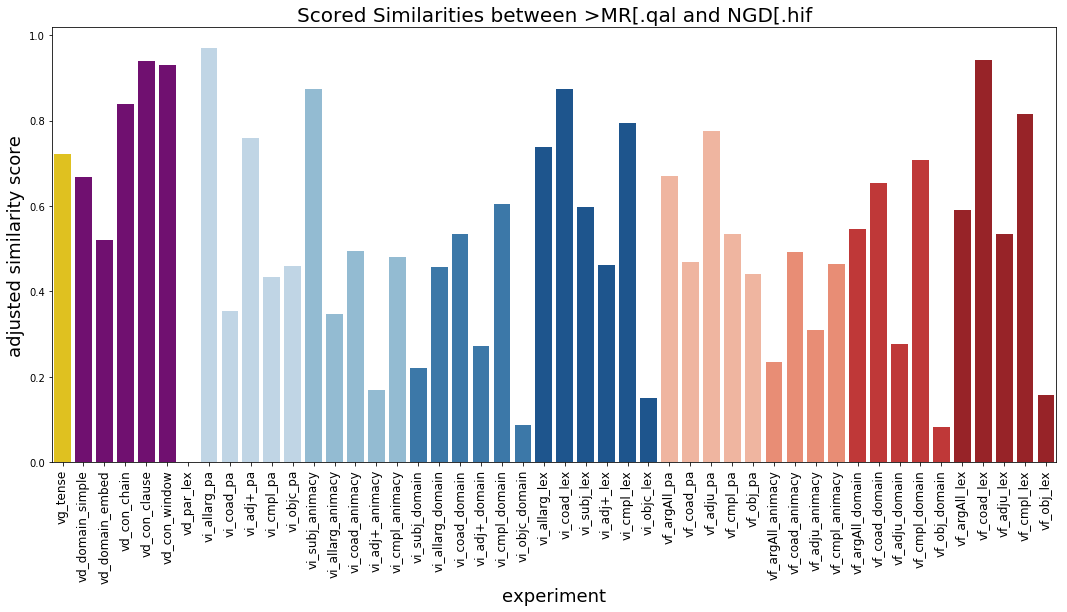

In [62]:
say_declare = get_sim_experiments('>MR[.qal', 'NGD[.hif')

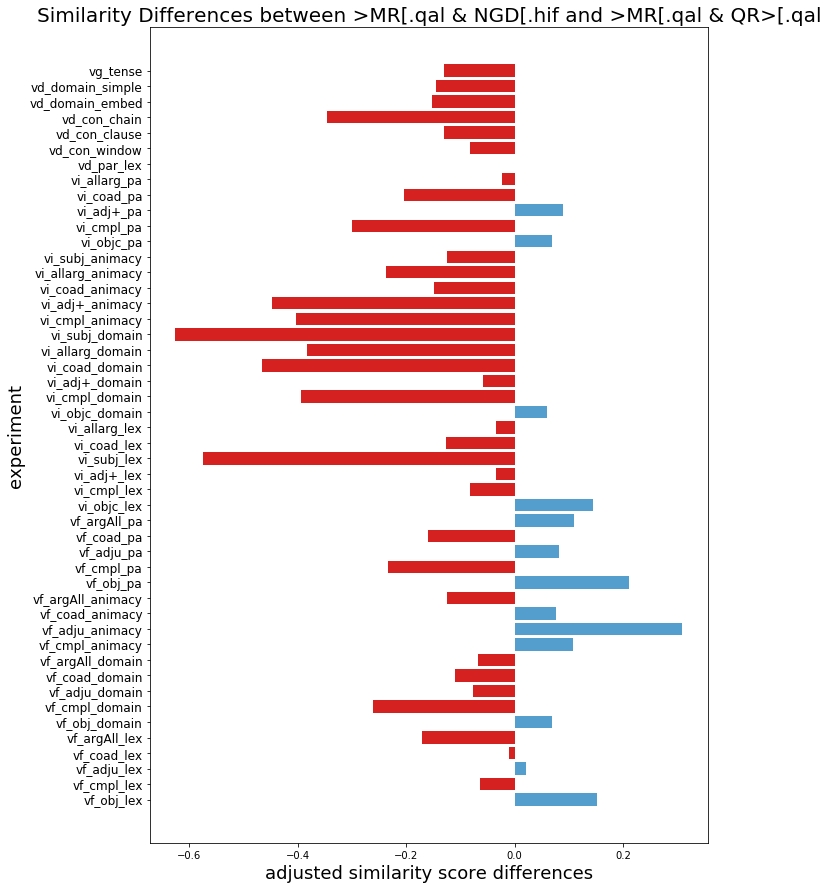

In [63]:
compareChange(('>MR[.qal', 'NGD[.hif'),('>MR[.qal', 'QR>[.qal'))

There are lot of decreases here across many categories. The biggest decrease comes in the subject domain and lex.

In [64]:
topUncommon('>MR[.qal', 'NGD[.hif', 'vi_subj_domain').head(10)

,difference,>MR[.qal,NGD[.hif
Compare,7.851749,7.851749,0.0
Titles,7.484764,7.484764,0.0
Lazy,7.266787,7.266787,0.0
Old,6.529821,6.529821,0.0
Names of Deities,6.096671,6.096671,0.0
Modification,5.851749,5.851749,0.0
Leaders,5.540352,5.540352,0.0
Small Animals,5.529821,5.529821,0.0
Sand,5.529821,5.529821,0.0
Messengers,5.436712,5.436712,0.0


There seems to be a lot more diversity in subjects for אמר, which is probably not surprising since it is a more common term. Below we look at differences from the perspective of NGD:

In [65]:
topUncommon('>MR[.qal', 'NGD[.hif', 'vi_subj_domain', focus='NGD[.hif').head(10)

,difference,>MR[.qal,NGD[.hif
Names of People,5.044394,5.404654,0.360260
Shout,4.392317,0.000000,4.392317
Tools,3.459432,0.000000,3.459432
Classes,3.321928,4.573764,1.251836
Universe,1.000000,1.642296,2.642296
Wise,1.000000,3.807355,2.807355
Perception,0.000000,2.722466,2.722466


The difference in potential values between the two terms is highlighted by seeing how many more values there are for >MR than NGD:

In [66]:
experiments['vi_subj_domain'].data['>MR[.qal'][experiments['vi_subj_domain'].data['>MR[.qal'] > 0].shape # non-zero counts

(50,)

In [67]:
experiments['vi_subj_domain'].data['NGD[.hif'][experiments['vi_subj_domain'].data['NGD[.hif'] > 0].shape

(9,)

There are only 9 subject features with נגד. This is likely a cause for many differences in lexical, animacy, and domain experiments. 

One key improvement in this pairing is the object preferences, especially as compared with the previous two pairings, which differed a lot in their preference for the object.

>MR[.qal
Objc    0.921019
ø       0.078981
Name: >MR[.qal, dtype: float64 

NGD[.hif
Objc    0.537975
ø       0.462025
Name: NGD[.hif, dtype: float64 



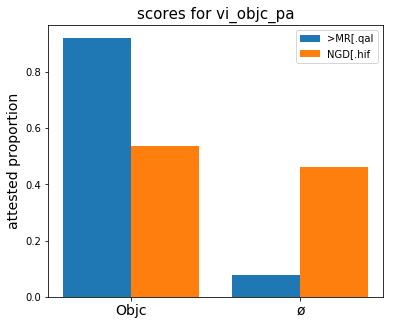

In [68]:
plotPa('>MR[.qal', 'NGD[.hif', 'vi_objc_pa')

While אמר and נגד still differ, the latter's 54% preference represents an increase over-against קרא.

>MR[.qal
animate      0.992513
inanimate    0.007487
Name: >MR[.qal, dtype: float64 

NGD[.hif
animate      0.903226
inanimate    0.096774
Name: NGD[.hif, dtype: float64 



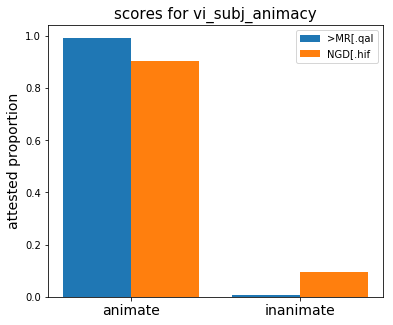

In [69]:
plotPa('>MR[.qal', 'NGD[.hif', 'vi_subj_animacy')

We can note that the complement experiments are lower except for in vf_cmpl_animacy where there is an increase in similarity:

In [70]:
topCommon('>MR[.qal', 'NGD[.hif', 'vf_cmpl_animacy').head(10)

,averaged,>MR[.qal,NGD[.hif
L_animate,3.564026,4.445276,2.682775


Here is the important category that we have seen in the latter two terms.

We can also see that ppmi has eliminated some otherwise similar terms from the frame experiment:

In [71]:
topCommon('>MR[.qal', 'NGD[.hif', 'vf_cmpl_animacy', count_type='raw').head(10)

,averaged,>MR[.qal,NGD[.hif
>L_animate,305.5,609.0,2.0
L_animate,123.0,190.0,56.0
L_inanimate,12.5,24.0,1.0
B_animate,3.5,2.0,5.0


Why does the similarity take such a hit in the inventory experiment?

In [72]:
topUncommon('>MR[.qal', 'NGD[.hif', 'vi_cmpl_animacy').head(7)

,difference,>MR[.qal,NGD[.hif
>L_animate,5.999025,5.999025,0.000000
L_inanimate,3.622353,3.622353,0.000000
<L_animate,2.476110,2.476110,0.000000
<L_inanimate,1.205904,1.205904,0.000000
L_animate,1.185032,4.388867,3.203835
B_animate,1.006648,0.000000,1.006648
MN_inanimate,0.000000,0.000000,0.000000


It would seem again that higher frequency of אמר as compared to נגד results in less common values between these two terms.

#### Analyzing Surprising אמר Matches

#### אמר and נתן

This is the first surprising pair which we will investigate. In which areas does this pairing differ from the non-surprising matches?

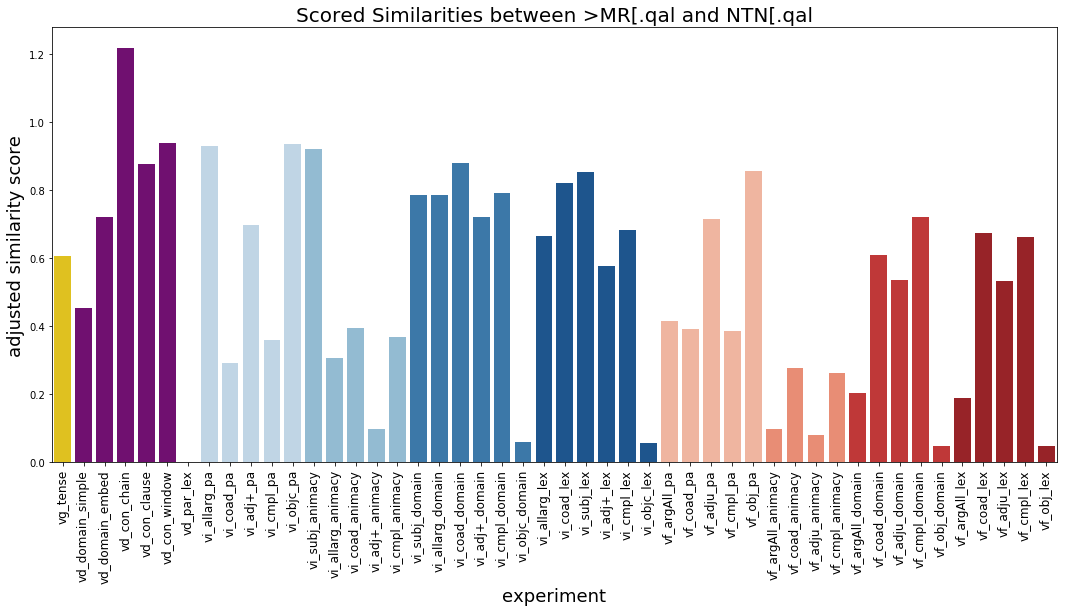

In [73]:
say_give = get_sim_experiments('>MR[.qal', 'NTN[.qal')

We can see high levels of agreement across object experiments. Yet, it is significant that this high level of agreement in the presence/absence of an object is not accompanied by high levels of agreement in the domain and lexeme experiments. This is suspect, since the high levels in complement experiments, by comparison, were also accompanied with high similarities across domain and lexeme. This may be an important observation.

And now, in comparison to the intuitively similar matches:

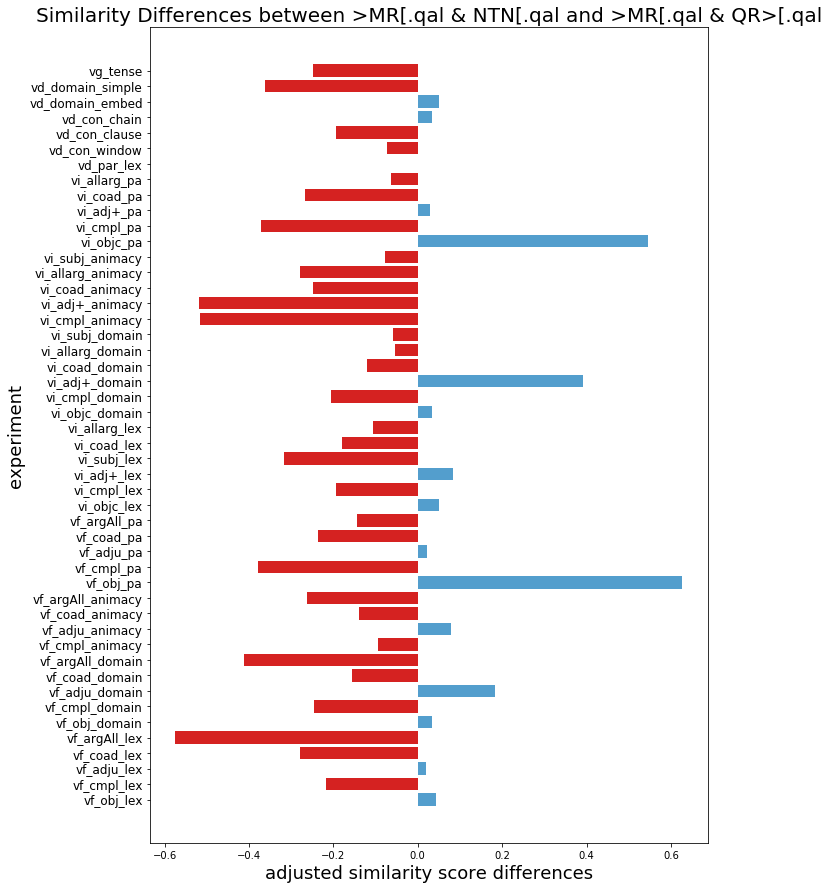

In [74]:
compareChange(('>MR[.qal', 'NTN[.qal'),('>MR[.qal', 'QR>[.qal'))

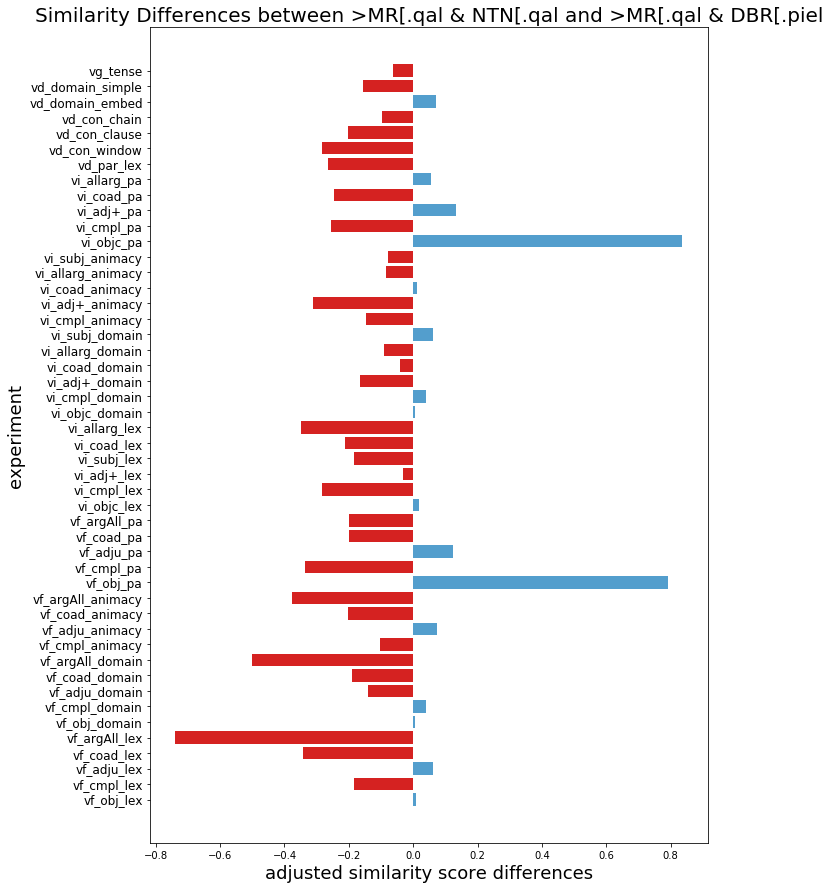

In [75]:
compareChange(('>MR[.qal', 'NTN[.qal'),('>MR[.qal', 'DBR[.piel'))

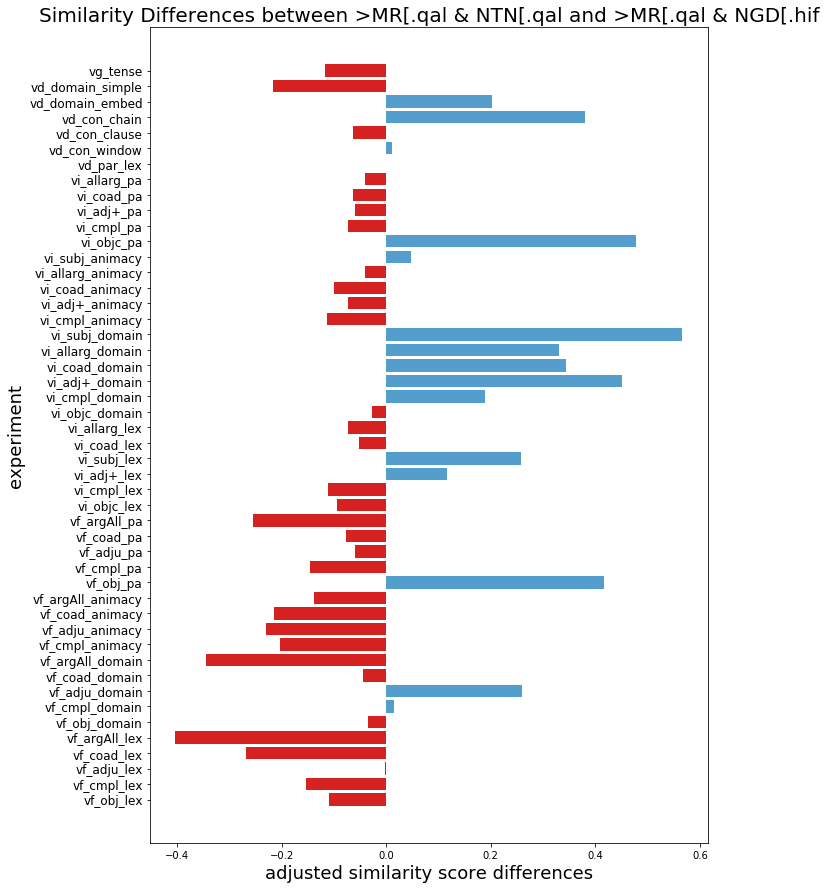

In [76]:
compareChange(('>MR[.qal', 'NTN[.qal'),('>MR[.qal', 'NGD[.hif'))

We can note a decrease across all three comparisons in the `vd_con_clause` experiment, indicating a different clause context for these three terms as compared with נתן.

Across all 3 intuitive matches we can see increased simmilarity in the object presence/absence experiments. This is reflected in the plot below.

>MR[.qal
Objc    0.921019
ø       0.078981
Name: >MR[.qal, dtype: float64 

NTN[.qal
Objc    0.875145
ø       0.124855
Name: NTN[.qal, dtype: float64 



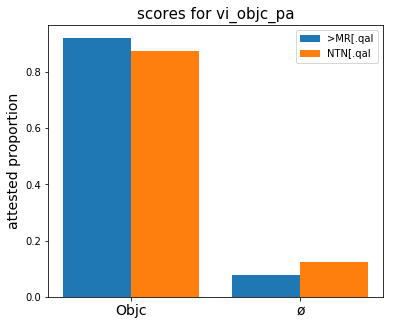

In [77]:
plotPa('>MR[.qal', 'NTN[.qal', 'vi_objc_pa')

>MR[.qal
Objc         0.917243
Objc|Objc    0.002377
ø            0.080380
Name: >MR[.qal, dtype: float64 

NTN[.qal
Objc         0.799870
Objc|Objc    0.060233
ø            0.139896
Name: NTN[.qal, dtype: float64 



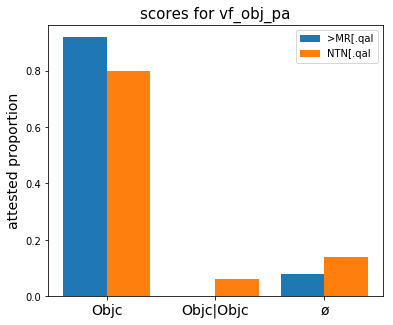

In [78]:
plotPa('>MR[.qal', 'NTN[.qal', 'vf_obj_pa')

None of the intuitive matches have such close similarity in the preference for objects. We also see that across all 3 pair comparisons there are decreases in the complement experiments.

>MR[.qal
Cmpl    0.375498
ø       0.624502
Name: >MR[.qal, dtype: float64 

NTN[.qal
Cmpl    0.827749
ø       0.172251
Name: NTN[.qal, dtype: float64 



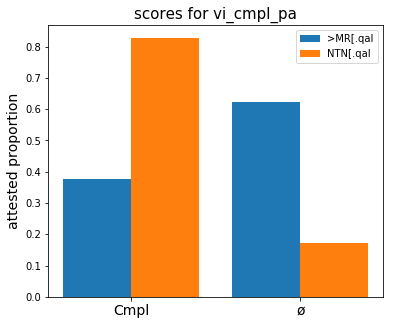

In [79]:
plotPa('>MR[.qal', 'NTN[.qal', 'vi_cmpl_pa')

נתן takes its complement 40% more often than אמר. Is it also higher than the other terms?

QR>[.qal
Cmpl    0.564615
ø       0.435385
Name: QR>[.qal, dtype: float64 

NTN[.qal
Cmpl    0.827749
ø       0.172251
Name: NTN[.qal, dtype: float64 



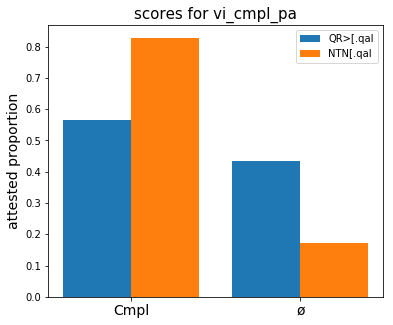

In [80]:
plotPa('QR>[.qal', 'NTN[.qal', 'vi_cmpl_pa')

NGD[.hif
Cmpl    0.776758
ø       0.223242
Name: NGD[.hif, dtype: float64 

NTN[.qal
Cmpl    0.827749
ø       0.172251
Name: NTN[.qal, dtype: float64 



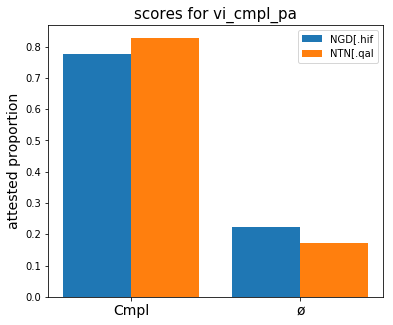

In [81]:
plotPa('NGD[.hif', 'NTN[.qal', 'vi_cmpl_pa')

Overall נתן prefers a complement much more often. Though it is close with נגד in the above experiment, this differs in the frame experiment where there is more distance.

NGD[.hif
Cmpl              0.683333
Cmpl|Cmpl         0.012500
Cmpl|Cmpl|Cmpl    0.000000
ø                 0.304167
Name: NGD[.hif, dtype: float64 

NTN[.qal
Cmpl              0.768451
Cmpl|Cmpl         0.045634
Cmpl|Cmpl|Cmpl    0.000563
ø                 0.185352
Name: NTN[.qal, dtype: float64 



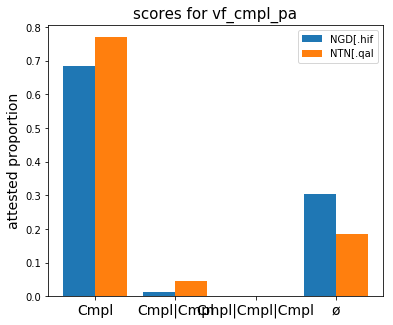

In [82]:
plotPa('NGD[.hif', 'NTN[.qal', 'vf_cmpl_pa')

Overall, we can see that אמר and נתן share closer similarities in their preference for objects but differ in their preference for complements. Namely, נתן requires the complement more often than אמר. These same tendencies are seen when נתן is compared against the other terms that are intuitively similar to אמר.

In short summary, here are some primary observations about the key differences between the intuitive matches and this surprising match:
* high similarity in presence/absence object experiments does not correspond with low similarity in object domain and lexeme experiments.
* differing preference for complements with a higher complement requirement for נתן
* decreased similarity in clause-internal context words

#### אמר and עשׂה

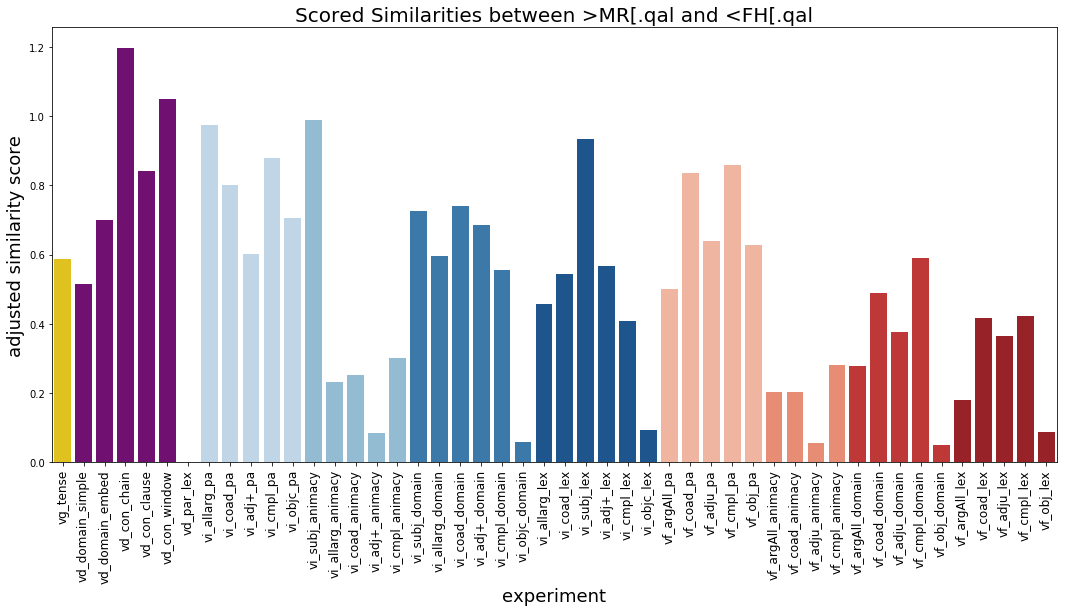

In [83]:
say_do = get_sim_experiments('>MR[.qal', '<FH[.qal')

As with נתן, we note high similarity in the object pa experiments with low agreement in the object domain and lexeme experiments. As compared with the previous example, though, we see higher levels of similarity in complement presence/absence for boh the frame and inventory experiments.

The vi subject lexeme experiment stands out due to low levels of similarity in the allarg, coad, adj+, and complement experiments. This situation is different as compared with נתן. 

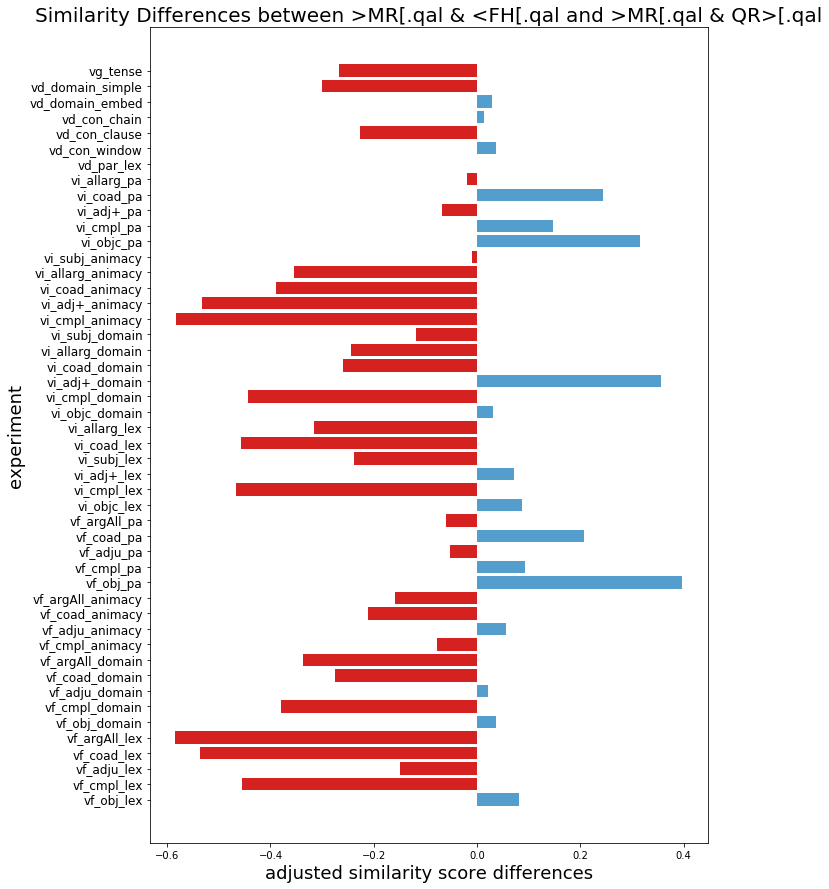

In [84]:
compareChange(('>MR[.qal', '<FH[.qal'),('>MR[.qal', 'QR>[.qal'))

We see large decreases in similarity across animacy, domain, and lexeme experiments. The highest increases are in the object experiments and adjunct domain.

The decreases across lexeme, domain, and animacy experiments that are accompanied by higher presence/absence experiments raises a question. Could it be that surprising matches frequently have higher grammatical similarity than contextual similarity? If we rearrange the order of the barchart, maybe those differences will be more apparent. We do that here and then test the resulting outcome.

In [85]:
# make NEW bar orders to test grammatical/contextual hypothesis
# we reorder the plots so that grammar comes first and context second
# bar order is handled under the colors argument of my plotting functions

grammar = '''
vg_tense
vi_allarg_pa
vi_coad_pa
vi_adj+_pa
vi_cmpl_pa
vi_objc_pa
vf_argAll_pa
vf_coad_pa
vf_adju_pa
vf_cmpl_pa
vf_obj_pa
'''.strip().split('\n')

context = '''
vd_domain_simple
vd_domain_embed
vd_con_chain
vd_con_clause
vd_con_window
vd_par_lex
vi_subj_animacy
vi_allarg_animacy
vi_coad_animacy
vi_adj+_animacy
vi_cmpl_animacy
vi_objc_animacy
vi_subj_domain
vi_allarg_domain
vi_coad_domain
vi_adj+_domain
vi_cmpl_domain
vi_objc_domain
vi_allarg_lex
vi_coad_lex
vi_subj_lex
vi_adj+_lex
vi_cmpl_lex
vi_objc_lex
vf_argAll_animacy
vf_coad_animacy
vf_adju_animacy
vf_cmpl_animacy
vf_obj_animacy
vf_argAll_domain
vf_coad_domain
vf_adju_domain
vf_cmpl_domain
vf_obj_domain
vf_argAll_lex
vf_coad_lex
vf_adju_lex
vf_cmpl_lex
vf_obj_lex
'''.strip().split('\n')

# map experiment groups to colors
color2experiment2 = ((reds[3], grammar),
                    (blues[4], context))

# make ordered tuple of colors
expcolors2 = tuple((exp, color) for color, exp_list in color2experiment2 # make tuple of colors
                        for exp in exp_list) 

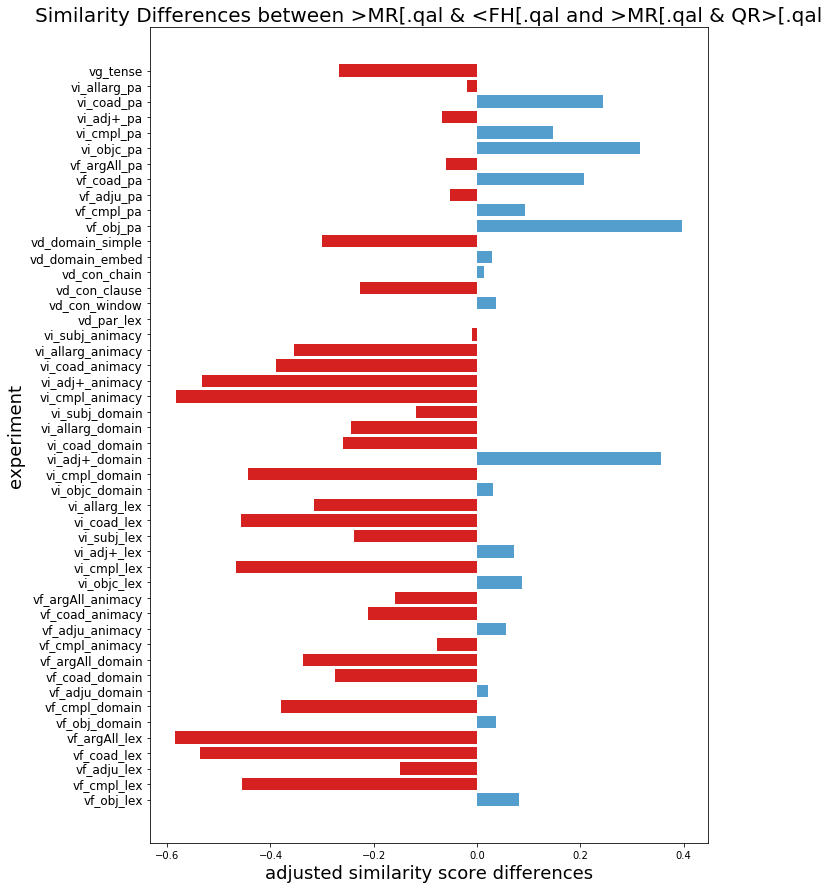

In [86]:
compareChange(('>MR[.qal', '<FH[.qal'),('>MR[.qal', 'QR>[.qal'), colors=expcolors2)

Here se can see that the biggest differences are towards the top of the graph, where the grammatical experiments have now been moved, though there are smaller changes below for object and adjuncts. The vi_adj+\_domain is the biggest contextual gain. There are also slight gains in context in the chain and window, but *not* in vd_con_clause. This is significant because above we saw vd_con_clause as an experiment that was likewise consistently higher amongst the three intuitive matches. Looking back to נתן, do we see a similar grammar/context divide in the new plot order?

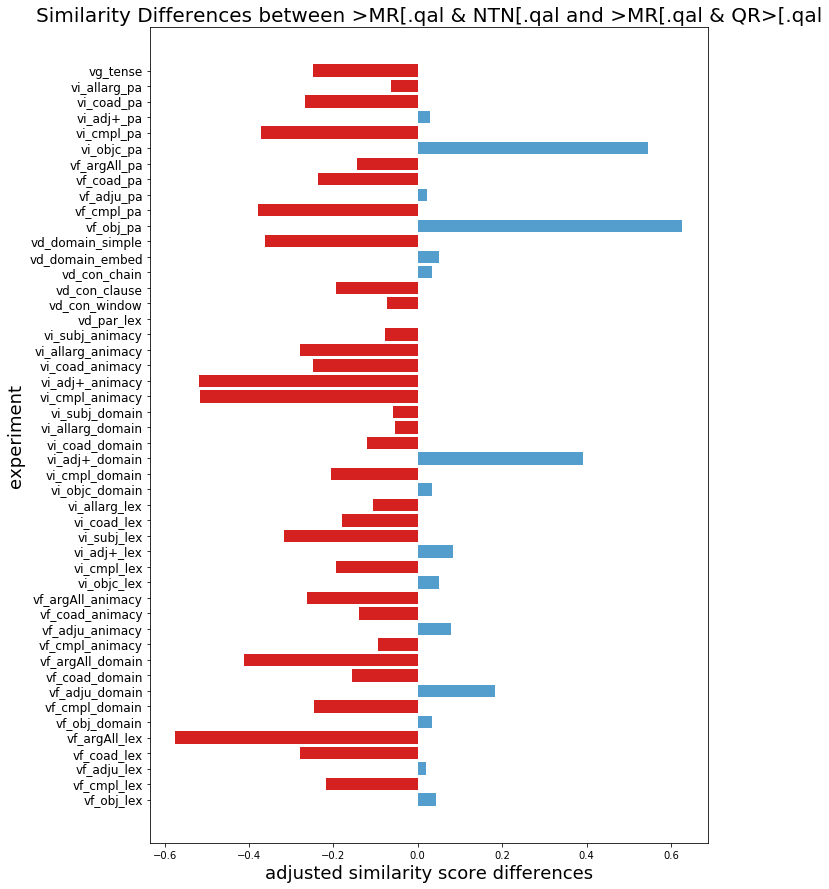

In [87]:
compareChange(('>MR[.qal', 'NTN[.qal'),('>MR[.qal', 'QR>[.qal'), colors=expcolors2)

Here too we see the biggest differences in the pa experiments, namely for object. There are also two bigger differences in context at adjunct (as seen above as well) and smaller increases in the object. We can again take note of the decrease in similarity in the vd_con_clause experiment. 

Returning to עשׂה, do we see the same grammar/context division with דבר and נגד as the comparison point?

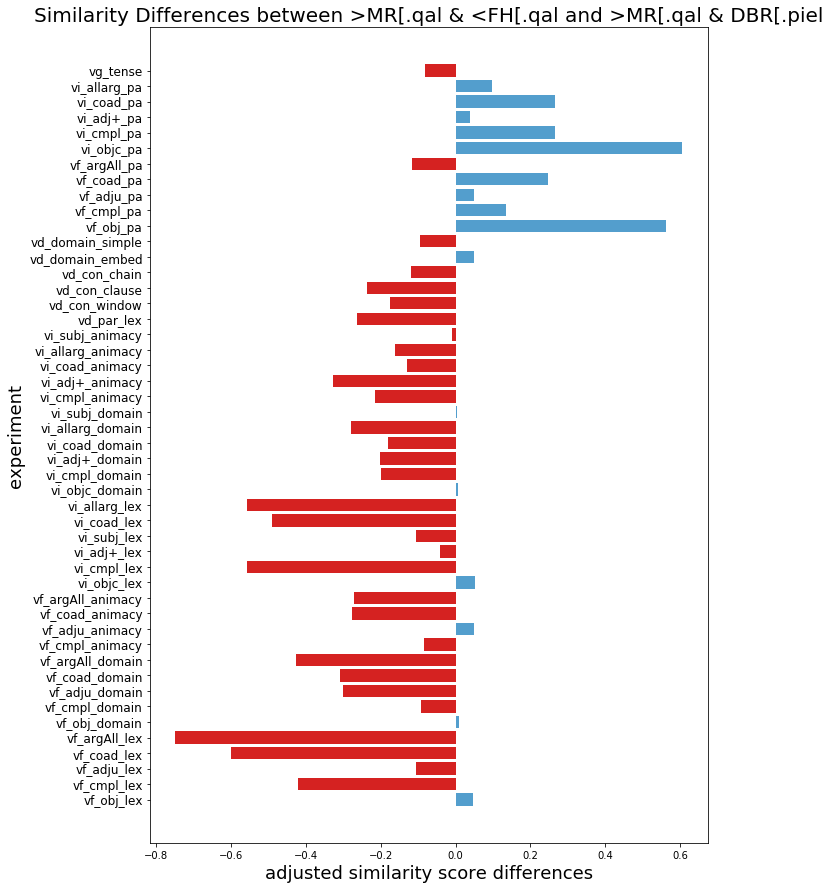

In [88]:
compareChange(('>MR[.qal', '<FH[.qal'),('>MR[.qal', 'DBR[.piel'), colors=expcolors2)

In this comparison the division is even more evident.

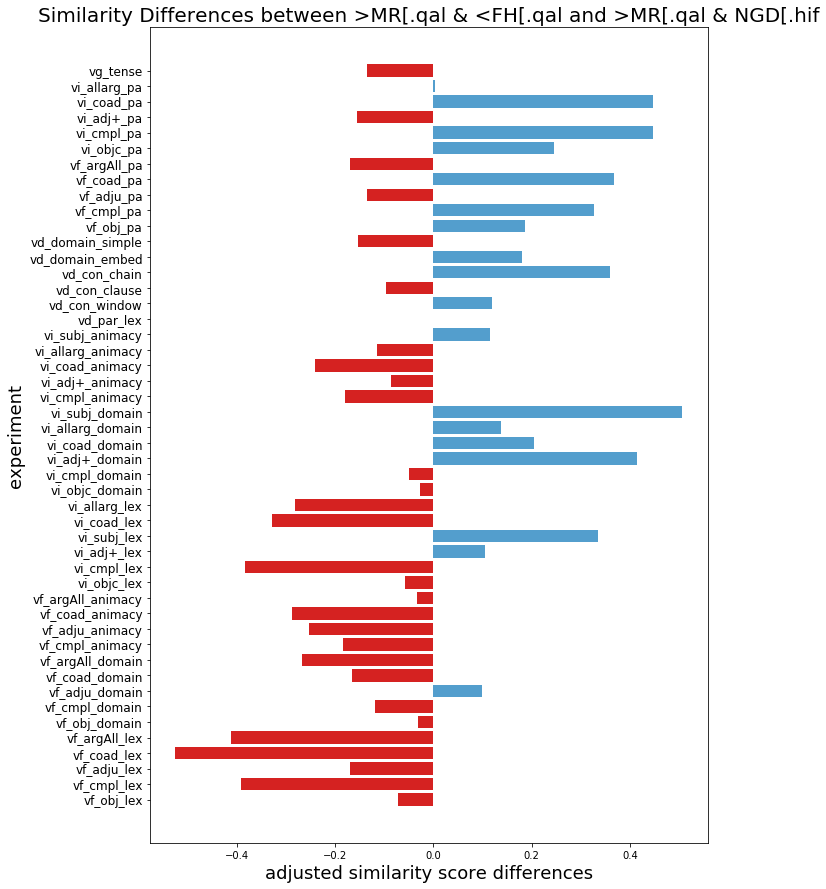

In [89]:
compareChange(('>MR[.qal', '<FH[.qal'),('>MR[.qal', 'NGD[.hif'), colors=expcolors2)

The tendency is less marked in the comparison with נגד. But we can note that the main gains in the context are restricted to the subject, allarg, coad, adj+ domains with no gains in complement or object domains. The same is true for the gains in subject and adjunct lexemes. Subject animacy is moderately increased. There is also a contextual increase in the domain_embed and con_chain categories. But we can see the indicative lower score for the vd_con_clause. Overall, the most substantive increases in similarity come in the pa experiments, as we have seen above.

To most thoroughly test the hypothesis, we will link every pa experiment score difference to its corresponding contextual experiment. We then plot all of the points and fit a line through them to look for a regression.

#### נתן Revisited

We've seen above that there seems to be a correlation between higher pa experiments, lower domain/lex experiments, and surprising matches. We've looked at the comparison of נתן with קרא above and saw that was so. What about the last two intuitive matches, דבר and נגד? 

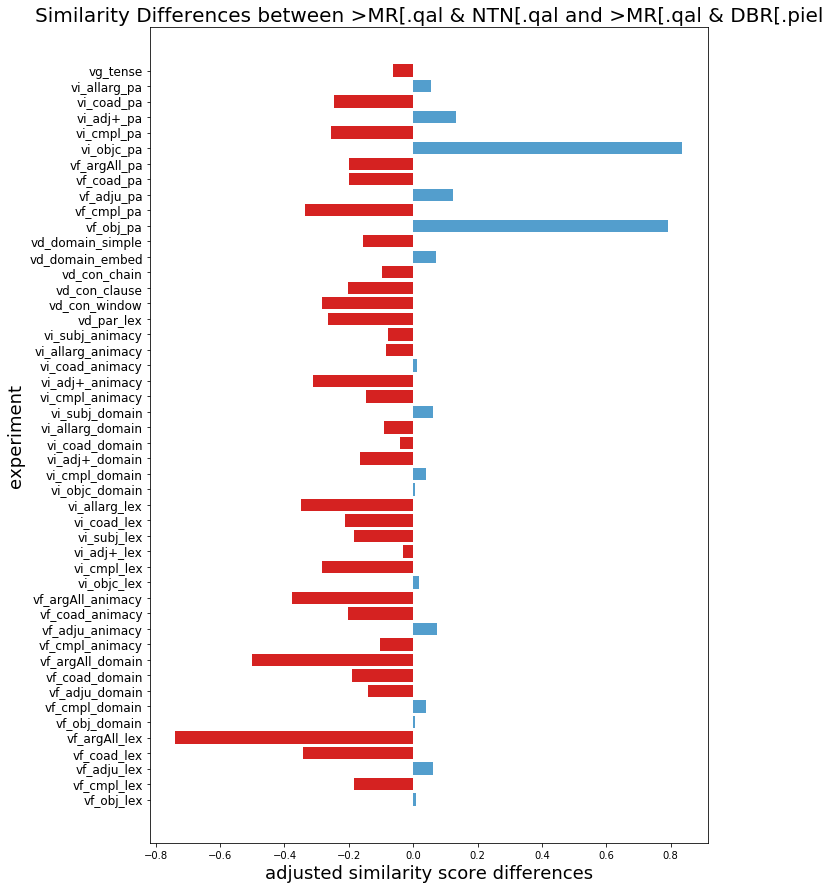

In [99]:
compareChange(('>MR[.qal', 'NTN[.qal'),('>MR[.qal', 'DBR[.piel'), colors=expcolors2)

Note that the increases in object presence/absence experiments here is accompanied with very slight increases in object domain and lexeme experiments. This is a different situation that we've seen in other surprising cases. What might be driving these improvements?

In [101]:
topCommon('>MR[.qal', 'NTN[.qal', 'vi_objc_lex')

,averaged,>MR[.qal,NTN[.qal
TCW<H/,5.667703,4.667703,6.667703
KBWD/,4.809956,3.580240,6.039672
QWL/,3.205297,0.912815,5.497778
<BD/,3.123382,2.123382,4.123382
R</,2.552226,2.552226,2.552226
<LH/,1.286881,1.286881,1.286881
DBR/,1.251914,1.620397,0.883432


Here we see some legitimate semantic similarities between speaking and giving. One can speak salvation, glory, words, as well as give them. Though, looking at these cases individually, we see that the senses may be different. In the cases with אמר, it seems that an adjunct or complement role might be a more appropriate tagging than object.

In [108]:
# B.show(experiments['vi_objc_lex'].target2basis2result['>MR[.qal']['<BD/']) # uncomment to peruse examples

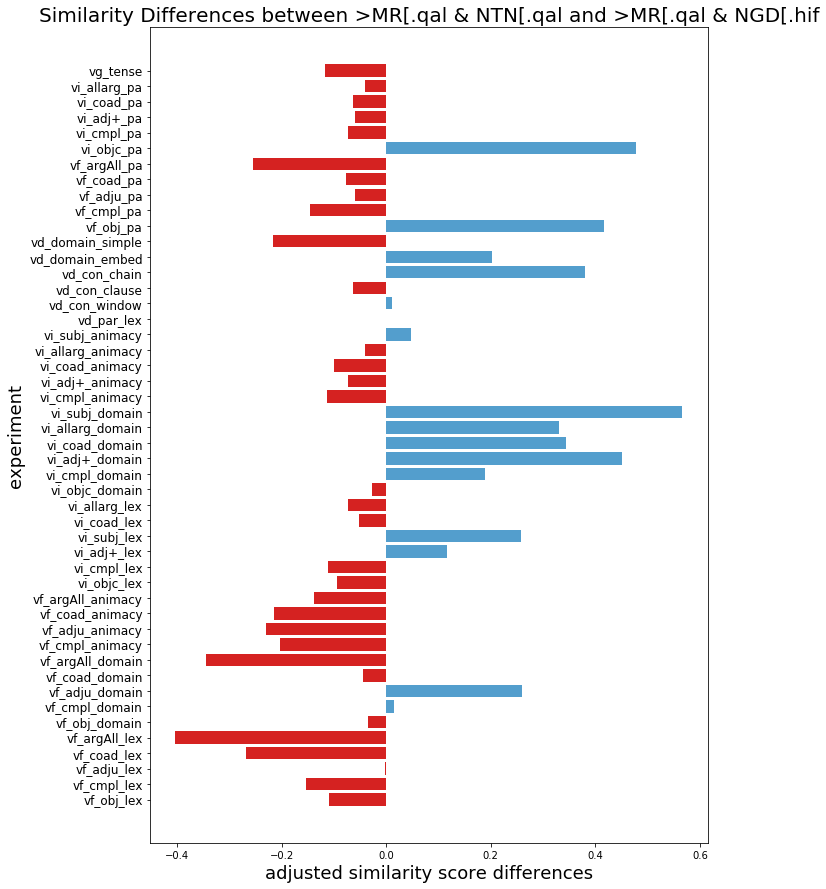

In [100]:
compareChange(('>MR[.qal', 'NTN[.qal'),('>MR[.qal', 'NGD[.hif'), colors=expcolors2)

In the case of דבר we can definitely see the grammar/context division. With נגד that is less clear. As we saw with עשׂה, the comparison to נגד yields improvements in the pa inventory domain experiments. However, we see that these gains do not fully translate to the pa frame experiments. Crucially, the large gains in the object presence/absence experiments is accompanied with similarity *decreases* in object domain and lexemes. We also see, as with the last cases, there is a decrease in `vd_con_clause` for both דבר and נגד.

### היה.qal

Similarity scores for HJH:


FJM[.qal    0.743461
<FH[.qal    0.695756
BW>[.hif    0.649756
LQX[.qal    0.615713
HJH[.qal    0.612082
Name: NTN[.qal, dtype: float64

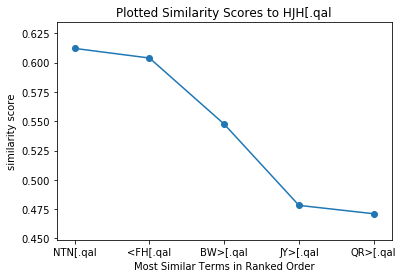

In [135]:
top_be = sim['HJH[.qal'].sort_values(ascending=False).head(5)
plotTop(top_be, 'HJH[.qal')
print('Similarity scores for HJH:')
top_give

All of the similar terms are surprising for this verb. There is thus the added difficulty here that there is no apparent intuitively similar term to test the surprising occurrences against. Across the first two verbs, though, some indicators are visible. In its comparisons with NTN and <FH the verb HJH rates low for experiments that test for objects. This can be seen for the comparisons with <FH and NTN:

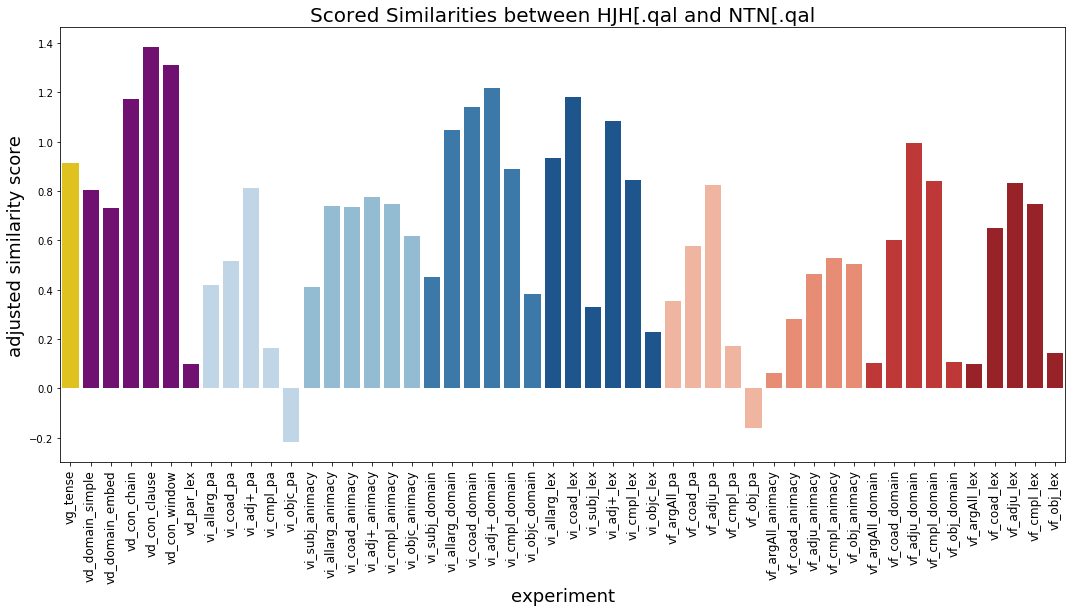

In [110]:
be_give = get_sim_experiments('HJH[.qal', 'NTN[.qal')

It is noteworthy that these negative similarities in object presence/absence are not accompanied with negative scores for object animacy, domain, or lexeme. Likewise, we see that comparatively lower scores for the complement presence/absence experiments do not quite show up in the animacy, domain, and lexical experiments. 

For the first time we see a low score for vi_subj_animacy, whereas with אמר the paired terms consistently scored higher in this experiment. This makes sense as היה is not strictly a verb with a living actant like אמר. 

It looks like there is indeed some parallelism that occurs between נתן and היה as evidenced by vd_par_lex.

Looking across the similarity chart as a whole, we see high scores for the adjunct experiments, especially in the vi_adj+\_domain. What kinds of common adjunct might these be?

In [113]:
topCommon('HJH[.qal', 'NTN[.qal', 'vi_adj+_domain').head(10)

,averaged,HJH[.qal,NTN[.qal
LM<N_Names of Locations,6.761551,6.761551,6.761551
B_Walls,6.761551,6.761551,6.761551
B_Leaders,6.761551,6.761551,6.761551
L_Divide,6.676589,7.176589,6.176589
<L_Space,6.676589,6.176589,7.176589
MN_Sacrifice,6.261551,5.761551,6.761551
MN_Non-Exist,6.261551,6.761551,5.761551
L_Flee,6.232104,6.439623,6.024586
L_Intact,6.176589,6.176589,6.176589
B_Hear,6.176589,6.176589,6.176589


In [114]:
topCommon('HJH[.qal', 'NTN[.qal', 'vi_adj+_lex').head(10)

,averaged,HJH[.qal,NTN[.qal
>L_QYH/,7.204571,7.204571,7.204571
B_PQD[,7.204571,7.204571,7.204571
B_MLWN/,7.204571,7.204571,7.204571
LM<N_JRWCLM/,7.204571,7.204571,7.204571
K_LBB/,7.119609,7.619609,6.619609
MN_>XZH/,7.119609,7.619609,6.619609
B_GWRL/,6.997052,6.204571,7.789534
L_>WR[,6.704571,7.204571,6.204571
L_>CH/,6.438324,5.034646,7.842001
B_CM<[,6.412090,7.204571,5.619609


We can see a lot of important similarities indicated with the L + verb or L + noun constructions. For instance, with L_Divide we can see a series of examples where something can be given or can be *as/for* something.

In [118]:
#B.show(experiments['vi_adj+_domain'].target2basis2result['HJH[.qal']['L_Divide']) # uncomment to peruse examples

In [119]:
#B.show(experiments['vi_adj+_domain'].target2basis2result['NTN[.qal']['L_Divide']) # uncomment to peruse examples

We can also note that the phrase לאישׁה is an easily recognizable similarity between these two verbs: to be "as a wife" and to be given "as a wife." Thus, the similarities in adjunct are important and do indeed show some cross over in semantic sense between נתן and היה.

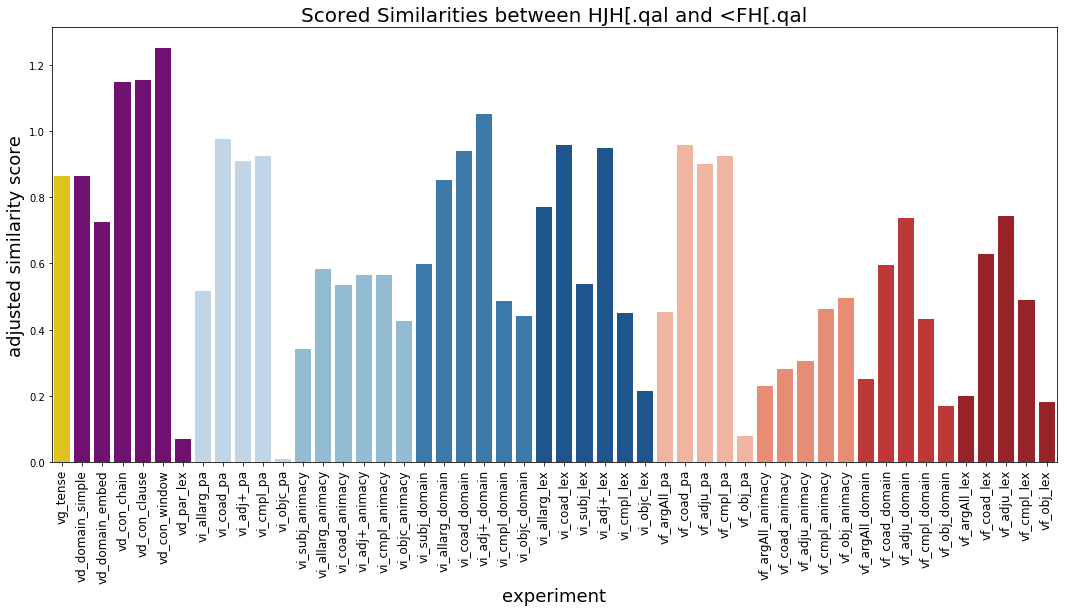

In [120]:
be_do = get_sim_experiments('HJH[.qal', '<FH[.qal')

As was the case with נתן, we see large drops in the presence/absence of an object. There is also a similarity drop in subject animacy. The strongest points of similarity appear to happen in the adjunct experiments, for all categories but animacy. The frame object animacy is notably higher in similarity by comparison to the other experiments in that group.

Moving to the next two verbs, בוא and יצא, there is a significant *increase* in similarity for the object pa experiments:

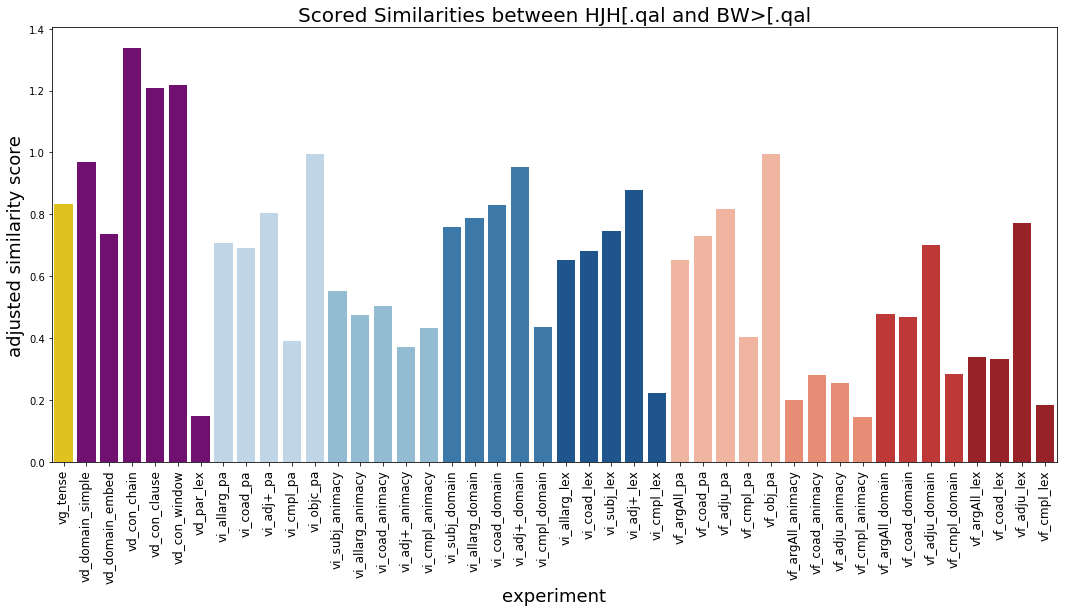

In [93]:
be_come = get_sim_experiments('HJH[.qal', 'BW>[.qal')

Here we can see the similarity between היה and the movement verb בוא in that they both often lack an object:

HJH[.qal
Objc    0.013037
ø       0.986963
Name: HJH[.qal, dtype: float64 

BW>[.qal
Objc    0.010526
ø       0.989474
Name: BW>[.qal, dtype: float64 



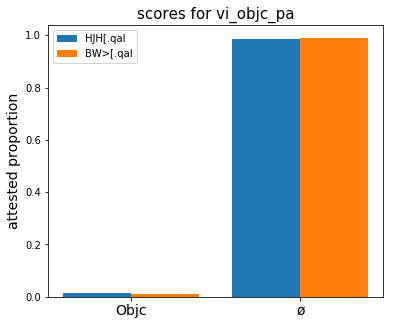

In [121]:
plotPa('HJH[.qal', 'BW>[.qal', 'vi_objc_pa')

Indeed, we would expect היה and בוא to *never* take an object. But the object's presence here is due to idiosyncrasies in the ETCBC encoding, which occasionally encodes complementized elements as objects. 

One key difference between היה and בוא comes in the complements experiments, where similarity is consistently lower.

HJH[.qal
Cmpl    0.237192
ø       0.762808
Name: HJH[.qal, dtype: float64 

BW>[.qal
Cmpl    0.667852
ø       0.332148
Name: BW>[.qal, dtype: float64 



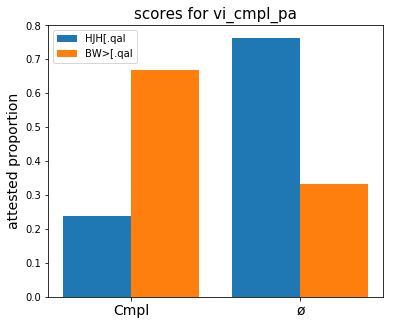

In [122]:
plotPa('HJH[.qal', 'BW>[.qal', 'vi_cmpl_pa')

In [123]:
topUncommon('HJH[.qal', 'BW>[.qal', 'vi_cmpl_lex').head(10)

,difference,HJH[.qal,BW>[.qal
<D=/,8.134426,8.134426,0.000000
B_M<RB=/,8.134426,8.134426,0.000000
CQV[,8.134426,0.000000,8.134426
CWR==/,8.134426,0.000000,8.134426
DN/,8.134426,0.000000,8.134426
DRK/_>JLM/,8.134426,0.000000,8.134426
DRK/_>TRJM/,8.134426,0.000000,8.134426
GZR=/,8.134426,0.000000,8.134426
KKR/,8.134426,8.134426,0.000000
K_<VH[,8.134426,8.134426,0.000000


The presence of locations in the complement lex inventory for בוא attests to its status as a movement verb. Notably, many of these slots are empty for היה. 

Finally, as with the last example, the category of adjunct experiments consistently score higher.

In [125]:
topCommon('HJH[.qal', 'BW>[.qal', 'vi_adj+_lex').head(10)

,averaged,HJH[.qal,BW>[.qal
>T==_<M/,7.204571,7.204571,7.204571
B_>CMRT/,7.204571,7.204571,7.204571
B_>CMH/,7.204571,7.204571,7.204571
ZKR=/,7.119609,6.619609,7.619609
B_CLX[,6.704571,7.204571,6.204571
B_QWM[,6.704571,6.204571,7.204571
B_MYWR=/,6.619609,6.619609,6.619609
B_NS<[,6.412090,7.204571,5.619609
L_<T/,6.251126,6.619609,5.882643
>XR/_DBR/,6.204571,7.789534,4.619609


One of the similarities we see here is the B + verb pattern which anchor the verb in an event.

In [129]:
#B.show(experiments['vi_adj+_lex'].target2basis2result['BW>[.qal']['B_QWM['])

In brief summary then, we see that היה and בוא share high similarities in their lack of an object as well as in their adjunct elements. This is different from the situation between היה and נתן and היה and עשׂה. However, they differ significantly in their preference for a complement.

As one last note, we can see a small increase in subject animacy as compared with the last cases.

HJH[.qal
animate      0.519796
inanimate    0.480204
Name: HJH[.qal, dtype: float64 

BW>[.qal
animate      0.836299
inanimate    0.163701
Name: BW>[.qal, dtype: float64 



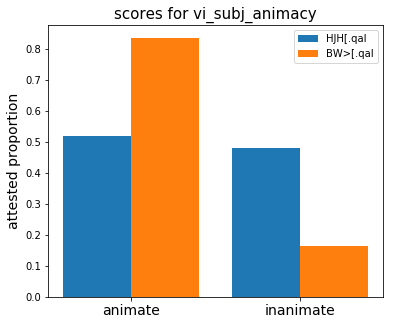

In [131]:
plotPa('HJH[.qal', 'BW>[.qal', 'vi_subj_animacy')

בוא has more inanimate subjects than we might expect. But perusing the cases in the HB shows how this verb is often used with non-living, but moving objects.

In [133]:
#B.show(experiments['vi_subj_animacy'].target2basis2result['BW>[.qal']['inanimate']) # uncomment to view full results

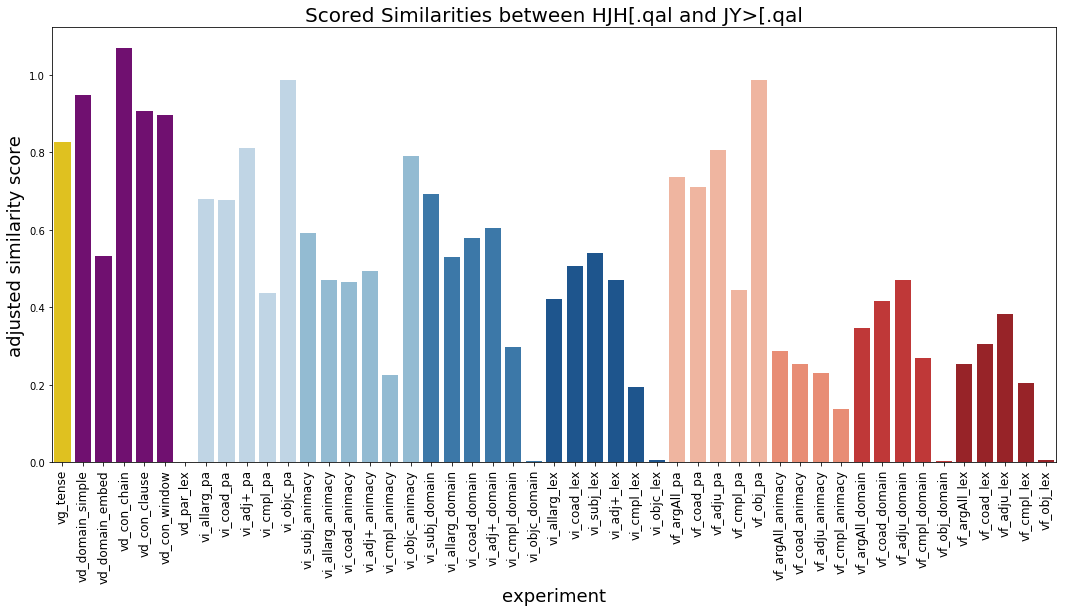

In [134]:
be_goout = get_sim_experiments('HJH[.qal', 'JY>[.qal')

Because there are no apparently intuitive verbs to compare against, the analysis of the HJH will need to await the analysis of the remaining verb forms. This way, we can use the knowledge gained from analysis of those verbs to understand the similarities with HJH better.

### נתן.qal

Similarity scores for NTN:


FJM[.qal    0.743461
<FH[.qal    0.695756
BW>[.hif    0.649756
LQX[.qal    0.615713
HJH[.qal    0.612082
Name: NTN[.qal, dtype: float64

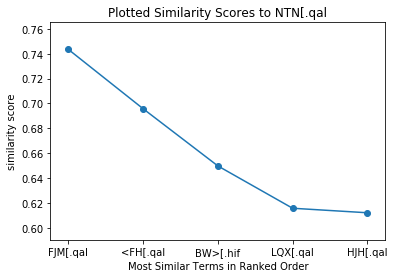

In [96]:
top_give = sim['NTN[.qal'].sort_values(ascending=False).head(5)
plotTop(top_give, 'NTN[.qal')
print('Similarity scores for NTN:')
top_give

There are three terms which are intuitively similar and two which are not:
* Intuitive: FJM[.qal, BW>[.hif, LQX[.qal (antonym)
* Surprising: <FH[.qal, HJH[.qal

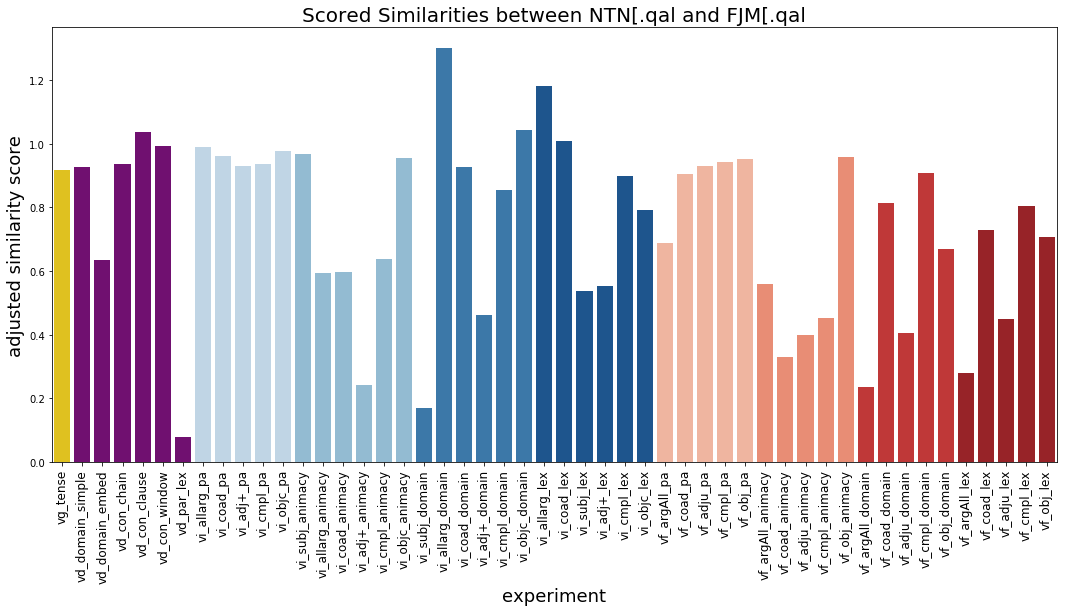

In [97]:
give_set = get_sim_experiments('NTN[.qal', 'FJM[.qal')

## Scratch Code

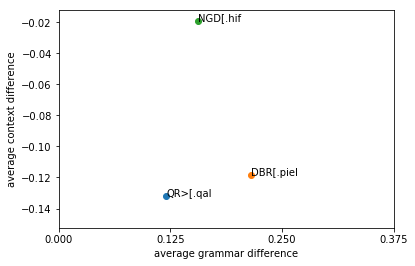

In [98]:
plt.figure(1)
avg_grams = list()
avg_conts = list()

for i, lex in enumerate(('QR>[.qal', 'DBR[.piel', 'NGD[.hif')):
    
    change = compareChange(('>MR[.qal', '<FH[.qal'), ('>MR[.qal', lex), showPlot=False, returnData=True)
    
    # get difference sums
    grammar_exps = np.array([diff for exp, diff in change.items() if re.match('.*_pa$', exp)])
    context_exps = np.array([diff for exp, diff in change.items() if exp not in set(grammar_exps)])
    
    # averaged diff sums
    avg_gram = grammar_exps.sum() / grammar_exps.shape[0]
    avg_cont = context_exps.sum() / context_exps.shape[0]
    plt.scatter(avg_gram, avg_cont)
    plt.annotate(lex, (avg_gram, avg_cont))
    plt.xticks(list(i/8 for i in range(0, 4)))
    plt.xlabel('average grammar difference')
    plt.ylabel('average context difference')
    
    avg_grams.append(avg_gram)
    avg_conts.append(avg_cont)

# b, m = polyfit(np.array(avg_grams), np.array(avg_conts), 1)
# plt.plot(b, m)    

plt.show()